# Topic analysis

Measure political party similarities over time.
1. Based on political topics:
    For each word (e.g., economy) measure the word overlap of the 10-20 nearest neighbours between parties.

2. Based on name embeddings:
    Word overlap of the 10-20 nearest neighbours.


### 1. Overlap of nearest neighbors for selected topics (kaiti and dina)

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import string
import os
import datetime

from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
from string import digits
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.interpolate import make_interp_spline, BSpline

tqdm.pandas()

In [2]:
parties_selected = ['κομμουνιστικο κομμα ελλαδας', 'συνασπισμος ριζοσπαστικης αριστερας', 'νεα δημοκρατια',
                    'πανελληνιο σοσιαλιστικο κινημα']

Read tell_all_corrected.csv, group by period and political party and join speeches. 

In [17]:
%%time
data = pd.read_csv("../out_files/tell_all_cleaned.csv")

CPU times: user 26.6 s, sys: 1.42 s, total: 28 s
Wall time: 30.1 s


In [19]:
data = data.drop(data[(data.political_party != 'νεα δημοκρατια') &
                     (data.political_party != 'κομμουνιστικο κομμα ελλαδας') &
                     (data.political_party != 'πανελληνιο σοσιαλιστικο κινημα') &
                     (data.political_party != 'συνασπισμος ριζοσπαστικης αριστερας')].index)

In [20]:
data.loc[(data.parliamentary_period=='period 5'), 'parliamentary_period'] = 'period 7'
data.loc[(data.parliamentary_period=='period 6'), 'parliamentary_period'] = 'period 7'
data.loc[(data.parliamentary_period=='period 14'), 'parliamentary_period'] = 'period 15'
data.loc[(data.parliamentary_period=='period 16'), 'parliamentary_period'] = 'period 17'

data['year'] = pd.DatetimeIndex(data['sitting_date']).year

In [21]:
# find min and max year of every period to use it in plots
min_max_years = {}

for period in data.parliamentary_period.unique():
    years = data.loc[data.parliamentary_period==period].year.unique()
    min_max_years[period] = [years.min(), years.max()]
    #data.loc[data.parliamentary_period==period]['period_years'] = [years.min(), years.max()]

In [26]:
data.head()

member_name sitting_date parliamentary_period  \
0  κρητικος νικολαου παναγιωτης   03/07/1989             period 7   
1  κρητικος νικολαου παναγιωτης   03/07/1989             period 7   
2  κρητικος νικολαου παναγιωτης   03/07/1989             period 7   
4  κρητικος νικολαου παναγιωτης   03/07/1989             period 7   
5  κρητικος νικολαου παναγιωτης   04/07/1989             period 7   

  parliamentary_session parliamentary_sitting                 political_party  \
0             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
1             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
2             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
4             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
5             session 1             sitting 2  πανελληνιο σοσιαλιστικο κινημα   

                                     government member_region  \
0  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
1  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
2  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
4  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
5  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   

                                              roles member_gender  \
0  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
1  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
2  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
4  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
5  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   

  speaker_info                                             speech  year  
0   προεδρευων  παρακαλειται @sw γραμματεας βουλγαρακης @sw συ...  1989  
1   προεδρευων  παρακαλειται @sw κυριος γραμματεας @sw συνοδευ...  1989  
2   προεδρευων  κυριοι συναδελφοι παρακαλω @sw βουλη @sw εξουσ...  1989  
4   προεδρευων  @sw βουλη παρεσχε @sw ζητηθεισα εξουσιοδοτηση....  1989  
5   προεδρευων  υπαρχει @sw @sw @sw κυριων συναδελφων @sw @sw ...  1989

In [27]:
%%time
data.to_csv('../out_files/speeches_split.csv')

CPU times: user 21.3 s, sys: 977 ms, total: 22.3 s
Wall time: 22.5 s


In [47]:
grouped_data = pd.read_csv('../out_files/speeches_split.csv')

In [6]:
%%time
grouped_data = grouped_data[grouped_data['speech'].notna()]

grouped_data = grouped_data.groupby(['parliamentary_period', 'political_party'])['speech'].progress_apply('. '.join).reset_index() # add missing dot from end of sentence
grouped_data['tokenised_speech'] = grouped_data.speech.progress_apply(lambda x: [sent.split(' ') for sent in x.split('.')])
grouped_data['tokenised_speech'] = grouped_data.tokenised_speech.progress_apply(lambda x: [token for token in x if token!='' and token!=' '])
grouped_data = grouped_data
grouped_data

100%|██████████| 35/35 [00:07<00:00,  4.83it/s]


CPU times: user 1min, sys: 1min 50s, total: 2min 51s
Wall time: 10min 17s


parliamentary_period                      political_party  \
0             period 10          κομμουνιστικο κομμα ελλαδας   
1             period 10                       νεα δημοκρατια   
2             period 10       πανελληνιο σοσιαλιστικο κινημα   
3             period 11          κομμουνιστικο κομμα ελλαδας   
4             period 11                       νεα δημοκρατια   
5             period 11       πανελληνιο σοσιαλιστικο κινημα   
6             period 11  συνασπισμος ριζοσπαστικης αριστερας   
7             period 12          κομμουνιστικο κομμα ελλαδας   
8             period 12                       νεα δημοκρατια   
9             period 12       πανελληνιο σοσιαλιστικο κινημα   
10            period 12  συνασπισμος ριζοσπαστικης αριστερας   
11            period 13          κομμουνιστικο κομμα ελλαδας   
12            period 13                       νεα δημοκρατια   
13            period 13       πανελληνιο σοσιαλιστικο κινημα   
14            period 13  συνασπισμος ριζοσπαστικης αριστερας   
15            period 15          κομμουνιστικο κομμα ελλαδας   
16            period 15                       νεα δημοκρατια   
17            period 15       πανελληνιο σοσιαλιστικο κινημα   
18            period 15  συνασπισμος ριζοσπαστικης αριστερας   
19            period 17          κομμουνιστικο κομμα ελλαδας   
20            period 17                       νεα δημοκρατια   
21            period 17       πανελληνιο σοσιαλιστικο κινημα   
22            period 17  συνασπισμος ριζοσπαστικης αριστερας   
23   period 18 review 9          κομμουνιστικο κομμα ελλαδας   
24   period 18 review 9                       νεα δημοκρατια   
25   period 18 review 9  συνασπισμος ριζοσπαστικης αριστερας   
26             period 7          κομμουνιστικο κομμα ελλαδας   
27             period 7                       νεα δημοκρατια   
28             period 7       πανελληνιο σοσιαλιστικο κινημα   
29             period 8          κομμουνιστικο κομμα ελλαδας   
30             period 8                       νεα δημοκρατια   
31             period 8       πανελληνιο σοσιαλιστικο κινημα   
32             period 9          κομμουνιστικο κομμα ελλαδας   
33             period 9                       νεα δημοκρατια   
34             period 9       πανελληνιο σοσιαλιστικο κινημα   

                                               speech  \
0   κυριε προεδρε κυριες @sw κυριοι βουλευτες @sw ...   
1   τελος επιστολη @sw βουλευτου περιφερειας θεσσα...   
2   παρακαλειται @sw προσωρινη γραμματεας φωτεινη ...   
3   κυρια προεδρε κυριες @sw κυριοι βουλευτες ομολ...   
4   κυριες @sw κυριοι συναδελφοι βαθυτατη συγκινησ...   
5   κυριες @sw κυριοι βουλευτες κηρυσσεται @sw ενα...   
6   κυρια προεδρε κυριες @sw κυριοι συναδελφοι @sw...   
7   κυριε προεδρε @sw επιτρεπετε. @sw @sw απλως @s...   
8   κυριες @sw κυριοι βουλευτες κηρυσσεται @sw ενα...   
9   κυριε προεδρε παρακαλω @sw μειωσετε @sw @sw χρ...   
10  ευχαριστω κυριε προεδρε.@sw @sw δυο @sw μηνες ...   
11  κυριε προεδρε παρακαλω @sw λογο. @sw εμπειρια ...   
12  κυριες @sw κυριοι βουλευτες κηρυσσεται @sw ενα...   
13  κυριες @sw κυριοι συναδελφοι αισθανομαι βαθυτα...   
14  ευχαριστω @sw κυριε προεδρε κυριες @sw κυριοι ...   
15  κυριες @sw κυριοι βουλευτες @sw προγραμματικες...   
16  κυριες @sw κυριοι βουλευτες συγκαλειται @sw βο...   
17  κυριε προεδρε καλεστε @sw διασκεψη. κυριες @sw...   
18  υπαρχει @sw @sw @sw συναδελφος @sw @sw ακουσε ...   
19  ευχαριστω κυρια προεδρε.@sw @κκε @sw @sw @sw α...   
20  κυριες @sw κυριοι βουλευτες συγκαλειται @sw βο...   
21  ευχαριστω κυρια προεδρε κυριες @sw κυριοι συνα...   
22  κυριες @sw κυριοι βουλευτες κυριες @sw κυριοι ...   
23  ευχαριστω @sw κυριε προεδρε.@sw προγραμματικες...   
24  κυριε προεδρε @sw κυβερνησεως κυριακο κωνσταντ...   
25  κυριες @sw κυριοι βουλευτες συγκαλειται @sw βο...   
26  κυριε προεδρε @sw κυριοι βουλευτες @sw παρον ν...   
27  κυριες @sw κυριοι συναδελφοι αναλαμβανοντας @s...   
28  παρακαλειται @sw γραμματεας βουλγαρακης @

In [7]:
grouped_data['period_number'] = grouped_data['parliamentary_period'].apply(lambda x: x.split()[1])#.astype(float)
grouped_data.period_number.unique()

array(['10', '11', '12', '13', '15', '17', '18', '7', '8', '9'],
      dtype=object)

In [31]:
grouped_data[grouped_data.political_party == 'συνασπισμος ριζοσπαστικης αριστερας']

parliamentary_period                      political_party  \
6             period 11  συνασπισμος ριζοσπαστικης αριστερας   
10            period 12  συνασπισμος ριζοσπαστικης αριστερας   
14            period 13  συνασπισμος ριζοσπαστικης αριστερας   
18            period 15  συνασπισμος ριζοσπαστικης αριστερας   
22            period 17  συνασπισμος ριζοσπαστικης αριστερας   
25   period 18 review 9  συνασπισμος ριζοσπαστικης αριστερας   

                                               speech  \
6   κυρια προεδρε κυριες @sw κυριοι συναδελφοι @sw...   
10  ευχαριστω κυριε προεδρε.@sw @sw δυο @sw μηνες ...   
14  ευχαριστω @sw κυριε προεδρε κυριες @sw κυριοι ...   
18  υπαρχει @sw @sw @sw συναδελφος @sw @sw ακουσε ...   
22  κυριες @sw κυριοι βουλευτες κυριες @sw κυριοι ...   
25  κυριες @sw κυριοι βουλευτες συγκαλειται @sw βο...   

                                     tokenised_speech period_number  
6   [[κυρια, προεδρε, κυριες, @sw, κυριοι, συναδελ...            11  
10  [[ευχαριστω, κυριε, προεδρε], [@sw, @sw, δυο, ...            12  
14  [[ευχαριστω, @sw, κυριε, προεδρε, κυριες, @sw,...            13  
18  [[υπαρχει, @sw, @sw, @sw, συναδελφος, @sw, @sw...            15  
22  [[κυριες, @sw, κυριοι, βουλευτες, κυριες, @sw,...            17  
25  [[κυριες, @sw, κυριοι, βουλευτες, συγκαλειται,...            18

### Implementation of local neighborhood measure for semantic shift from Hamilton's paper
Section 2.1 https://www.aclweb.org/anthology/D16-1229/

#### Update  models with specified values for hyperparameters

In [61]:
%%time
# !! run once !!

from tqdm import tqdm
from gensim.models import Word2Vec
import nltk

for party in grouped_data.political_party.unique():
    for period in grouped_data.parliamentary_period.unique():
        if not grouped_data['tokenised_speech'].loc[(grouped_data.political_party == party) &
                     (grouped_data.parliamentary_period == period)].empty:
            per_period_speeches = grouped_data['tokenised_speech'].loc[(grouped_data.political_party == party) &
                     (grouped_data.parliamentary_period == period)].values[0]
            print(per_period_speeches[0][:100])
            try:
                print(party, period)
                model = Word2Vec(sentences=per_period_speeches, 
                         size=300, window=5, min_count=20, workers=1)
                model.save(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{period}.mdl")
            except:
                continue

['κυριε', 'προεδρε', 'κυριες', '@sw', 'κυριοι', 'βουλευτες', '@sw', 'πρωθυπουργος', 'υπογραμμισε', '@sw', '@sw', '@sw', 'στιγμη']
κομμουνιστικο κομμα ελλαδας period 10
['κυρια', 'προεδρε', 'κυριες', '@sw', 'κυριοι', 'βουλευτες', 'ομολογω', '@sw', '@sw', '@sw', '@sw', '@sw', 'προγραμματικες', 'δηλωσεις', '@sw', '@sw', '@sw', 'καραμανλης', '@sw', '@sw', '@sw', 'ομιλια', '@sw', 'γιωργου', 'παπανδρεου', '@sw', '@sw', 'καταλαβω', '@sw', '@sw', '@sw', '@sw', '@sw', 'καταλαβει', '@sw', '@sw', '@sw', '@sw', 'σημαινει', 'πολιτικος', 'πολιτισμος']
κομμουνιστικο κομμα ελλαδας period 11
['κυριε', 'προεδρε', '@sw', 'επιτρεπετε']
κομμουνιστικο κομμα ελλαδας period 12
['κυριε', 'προεδρε', 'παρακαλω', '@sw', 'λογο']
κομμουνιστικο κομμα ελλαδας period 13
['κυριες', '@sw', 'κυριοι', 'βουλευτες', '@sw', 'προγραμματικες', 'δηλωσεις', '@sw', 'κυβερνησης', '@sw', 'πλαισιο', '@sw', 'βαθιας', 'καπιταλιστικης', 'κρισης', '@sw', '@sw', '@sw', 'αδιεξοδων', '@sw', 'γενναει', '@sw', 'αστικη', 'πολιτικη', 'διαχειρι

['κυριε', 'προεδρε', 'παρακαλω', '@sw', 'μειωσετε', '@sw', '@sw', 'χρονο', '@sw', 'κοινοβουλευτικων', 'εκπροσωπων', '@sw', '@sw', 'υπουργων', '@sw', '@sw', '@sw', 'βουλευτων']
πανελληνιο σοσιαλιστικο κινημα period 12
['κυριες', '@sw', 'κυριοι', 'συναδελφοι', 'αισθανομαι', 'βαθυτατη', 'συγκινηση', '@sw', '@sw', '@sw', 'αποφαση', '@sw', '@sw', '@sw', 'αναθεσατε', '@sw', 'καθηκοντα', '@sw', 'προεδρου', '@sw', 'βουλης', '@sw', 'ελληνων']
πανελληνιο σοσιαλιστικο κινημα period 13
['κυριε', 'προεδρε', 'καλεστε', '@sw', 'διασκεψη']
πανελληνιο σοσιαλιστικο κινημα period 15
['ευχαριστω', 'κυρια', 'προεδρε', 'κυριες', '@sw', 'κυριοι', 'συναδελφοι', '@sw', 'γνωριζετε', '@sw', 'βλεπετε', 'καλυτερα', '@sw', 'μενα', '@sw', '@sw', 'μερες', '@sw', 'χωρα', '@sw', 'δοκιμαζεται']
πανελληνιο σοσιαλιστικο κινημα period 17
['παρακαλειται', '@sw', 'γραμματεας', 'βουλγαρακης', '@sw', 'συνοδευσει', '@sw', 'μακαριοτατο', 'αρχιεπισκοπο', 'αθηνων', '@sw', 'πασης', 'ελλαδος', 'σεραφειμ', '@sw', '@sw', 'συνοδευοντα'

In [32]:
def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]

In [33]:
df = grouped_data
df.period_number = df.period_number.astype('int')
df = df.sort_values(by='period_number')
periods = list(df.parliamentary_period.unique())
period_pairs = step_one_pairs(periods)
pd.Series(period_pairs).unique()

array([('period 7', 'period 8'), ('period 8', 'period 9'),
       ('period 9', 'period 10'), ('period 10', 'period 11'),
       ('period 11', 'period 12'), ('period 12', 'period 13'),
       ('period 13', 'period 15'), ('period 15', 'period 17'),
       ('period 17', 'period 18 review 9')], dtype=object)

In [11]:
%%time
## find words that should be filtered
from collections import Counter

filtered_words = {}
filtered_neighbours = {}
all_words = {}
most_frequent_dict = {}

for party in grouped_data.political_party.unique():
    for period in grouped_data.parliamentary_period.unique():
        try:
            m = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{period}.mdl")
        except:
            continue
        forbidden_words = []
        freq_df = pd.DataFrame()
        
        lower200 = [key for key in m.wv.vocab if m.wv.vocab[key].count <= 200]
        lower100 = [key for key in m.wv.vocab if m.wv.vocab[key].count <= 100]
        forbidden_words = lower200
        
        freq_df['word'] = m.wv.vocab
        freq_df['occurences'] = [m.wv.vocab[key].count for key in m.wv.vocab]
        freq_df = freq_df.sort_values(by=['occurences'], ascending=False)

        most_frequent = list(freq_df.head(200).word)
        #print(most_frequent)
        #forbidden_words.extend(most_frequent) #avoid removing top frequent
        
        num_of_cells = int(len(freq_df)*0.2)
        least_frequent = list(freq_df.tail(num_of_cells).word)
        
        forbidden_words.extend(least_frequent)
        forbidden_words = set(forbidden_words) # we convert to set to keep remove duplicates

        filtered_words[f"{party}-{period}"] = list(forbidden_words)
        filtered_neighbours[f"{party}-{period}"] = lower100
        all_words[f"{party}-{period}"] = list(freq_df.word)
        most_frequent_dict[f"{party}-{period}"] = list(freq_df.head(200).word)
        print(freq_df.head(200))

                  word  occurences
@sw                @sw      942323
                              8258
κυριε            κυριε        5337
κυβερνηση    κυβερνηση        4314
υπαρχει        υπαρχει        4118
...                ...         ...
μεγαλα          μεγαλα         470
γεγονος        γεγονος         466
κοινωνικο    κοινωνικο         465
αναφερεται  αναφερεται         464
φαινεται      φαινεται         464

[200 rows x 2 columns]
              word  occurences
@sw            @sw      945382
                          9368
κυριε        κυριε        5427
@sw’          @sw’        4402
υπαρχει    υπαρχει        4322
...            ...         ...
σημερινη  σημερινη         462
συζηταμε  συζηταμε         462
αρχη          αρχη         459
ζωη            ζωη         457
αγορα        αγορα         457

[200 rows x 2 columns]
              word  occurences
@sw            @sw      713173
                          8508
κυριε        κυριε        4064
@sw’          @sw’        3348
πολιτ

                word  occurences
@sw              @sw     2780171
                           28704
κυριε          κυριε       28265
προεδρε      προεδρε       13059
κυβερνηση  κυβερνηση       12612
...              ...         ...
αναπτυξη    αναπτυξη        1286
4                  4        1276
παιδειας    παιδειας        1271
ελληνες      ελληνες        1264
χωρες          χωρες        1259

[200 rows x 2 columns]
                  word  occurences
@sw                @sw     5036012
                             78772
κυριε            κυριε       35945
λογο              λογο       23171
υπαρχει        υπαρχει       20424
...                ...         ...
σημαινει      σημαινει        2822
κοινωνια      κοινωνια        2799
αναφερεται  αναφερεται        2797
αγορα            αγορα        2779
δικαιωμα      δικαιωμα        2767

[200 rows x 2 columns]
                    word  occurences
@sw                  @sw     3965717
                               36468
κυριε              κυριε 

In [35]:
%%time
## find common vocabulary of every party + remove filtered words
forbidden_words_all = {}

for party in parties_selected:
    periods = list(grouped_data.loc[grouped_data.political_party==party].parliamentary_period.unique())
    for i in range(0,len(periods) -1): #periods are sorted
        first_period = periods[i]
        second_period = periods[i+1]
        
        forbidden_first_period = filtered_words[f"{party}-{first_period}"]
        forbidden_second_period = filtered_words[f"{party}-{second_period}"]
        
        forbidden_words = set(forbidden_first_period).union(set(forbidden_second_period))
        
        if i != 0:
            forbidden_words_all[f"{party}"] = set(forbidden_words_all[f"{party}"]).union(set(forbidden_words))
        else:
            forbidden_words_all[f"{party}"] = forbidden_words

CPU times: user 203 ms, sys: 14.9 ms, total: 218 ms
Wall time: 357 ms


In [27]:
len(filtered_neighbours[f"κομμουνιστικο κομμα ελλαδας-period 7"])

3192

In [73]:
len(all_words[f"κομμουνιστικο κομμα ελλαδας-period 7"])

46870

In [57]:
m1 = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/συνασπισμος ριζοσπαστικης αριστερας_periodperiod 15.mdl")
for w in m1.wv.vocab:
     print (w, m1.wv.vocab[w].count)

υπαρχει 6159
@ 1870351
sw 1858742
συναδελφος 396
ακουσε 37
ονομα 407
κυριες 3081
κυριοι 5292
συναδελφοι 4028
υπενθυμισω 76
σωμα 1172
αρθρο 4229
7 683
παραγραφο 400
3 1383
κανονισμου 304
βουλης 2058
προεδρος 666
σωματος 258
απολυτη 241
πλειοψηφια 3174
αριθμου 83
βουλευτων 535
. 120014
επιτευχθει 61
υποψηφιος 32
ψηφους 39
ολοκληρωθει 194
κηρυσσεται 47
περαιωμενη 54
ψηφοφορια 374
παρακαλω 960
κυριους 76
προβουν 20
καταμετρηση 22
εξαγωγη 24
τιμη 695
ανακοινωσω 277
αποτελεσμα 975
ψηφοφοριας 135
εκλογη 62
προεδρου 332
συνολικα 393
βουλευτες 2612
ελαβε 52
βρεθηκαν 54
λευκα 20
2 1644
ελληνων 569
προεδρο 446
προεδρειο 679
καταλαβει 239
εδρα 90
προεδρε 8625
ενσταση 121
διαδικασιας 415
συζητηθει 529
ομιλια 374
κυριου 469
πρωθυπουργου 305
συμφωνησει 91
ζητησουμε 59
κυριο 918
πρωθυπουργο 243
διαδικασια 2271
ειπα 1042
μιλησει 405
κυριος 1540
πρωθυπουργος 412
κυριε 14196
’ 8987
αρχας 418
καλη 288
αυτονοητο 139
κρισιμη 114
φαση 167
συνεδριαση 652
προγραμματικες 88
δηλωσεις 321
αιτημα 433
απλο 214
ζητα

αποσυρθει 155
δωσετε 577
τελειωσω 127
ολοκληρωσω 115
οικογενειες 301
καταργουνται 153
σχολες 137
τιτλοι 22
τιτλους 50
σπουδες 69
βιου 75
μαθησης 33
ηξερε 46
αυτοδιοικητο 38
οργανων 98
ρητρες 75
αρθρου 642
16 276
καθιστωντας 21
ευχαριστωκυριε 210
αφησετε 66
καταθετουμε 101
ημερες 357
αμεσες 60
θεσμικες 38
τεσσερα 516
εγκριση 163
προυπολογισμων 25
θεσμικη 126
μεριμνας 35
αμεσο 77
διορισμο 65
μελων 224
δεπ 20
καλει 67
καταστατικο 20
μαζεψει 26
προετοιμασια 40
βουλευτικη 74
τραγικη 114
ειρωνεια 37
προσωπικο 1010
εκτελει 23
εκποιησης 53
παρουσια 270
σκληρο 73
γνωρισει 21
εθνικης 643
μορφωμα 26
βαθιας 25
διαλυοντας 23
ισχυριζονται 21
ξεπερασουμε 20
προβληματα 1343
ασφαλη 47
επικαλουνται 39
δοξα 25
μαρτυρες 80
βλεπουν 111
σιγουρα 166
βιωνουν 80
αρχες 446
δεκαετιας 46
90 152
κοινοτικων 34
κονδυλιων 87
ψυχιατρικη 41
εργαζομενοι 943
αναζητουν 26
τροφιμα 27
ασθενεις 256
ευαισθητο 58
ψυχικα 50
πασχοντες 39
απιστευτη 51
παραδιδεται 20
ναρκωτικων 72
αξιας 205
νοσηματα 30
ουρα 34
εξεταστουν 31
κοψει 

αναπτυξουμε 37
επιστημη 50
σοφια 40
αδιεξοδα 69
μεταβατικη 35
ανοιξουμε 42
θεσμικο 202
οικογενειακο 59
νεος 189
παροτι 39
παρεχει 136
ζητουμενο 81
τοποθετηθει 136
επαρχια 50
καταδικη 60
φτωχος 33
επιδειξη 24
ισχυος 92
γεωργιαδης 187
μειζονα 46
σαφηνεια 84
ανελυσε 31
βοριδης 228
θυσια 53
ετοιμος 47
ματ 208
βοριδη 264
χωροι 80
λειτουργουν 351
θεσμος 89
προσφατη 91
ελλαδος 271
περιοδους 73
θεσμικης 30
διπλης 30
αποσυρεται 38
μεταφερει 70
ανατιθεται 22
φθηνο 68
αδιπ 25
ελληνικες 167
πρωτου 445
επιστημης 32
προυποθετει 58
διαμορφωνει 45
επιστημονικης 109
μαθηση 22
χριστοφιλοπουλου 57
επιστημονικη 304
δομη 141
σκεψης 30
επιτροπος 28
θεσμοθετειτε 23
σταθουμε 34
εμποδιο 48
τιτλων 33
αντιληψεις 39
προσπαθησει 23
διαμορφωσει 49
καλυψει 151
βητα 20
αυξησεις 141
επιμεινετε 29
ακολουθειτε 105
βρεθουμε 27
πληττεται 41
υπολοιπα 261
παιξει 79
παιζουν 71
παιχνιδι 99
διαφορετικης 25
αντιληψης 53
μαρασμο 29
καταλαβαινουμε 164
ιδρυματος 80
συγκροτειται 23
ιδρυμα 157
εισηγηση 125
πρυτανη 20
κυκλο 120
απιστ

ορισμενου 56
δημοτικες 38
κριθει 81
αναλγησια 44
εδωσα 34
διαβαζετε 64
αστεγοι 27
εφυγαν 48
επιδοτησεις 91
φοροαπαλλαγες 86
χιλιοι 72
55 91
φοβερο 44
λειτουργειτε 27
μπομπολα 21
πρωτογενη 146
λατση 41
μουσειο 75
εθνικους 42
συνεχους 20
πλαφον 73
μετατρεπετε 49
νεοφιλελευθερων 50
αντιδρασει 31
παππα 37
επιβαρυνσεις 54
διατυπωσεις 43
παρατηρησεις 193
διευκρινισω 28
βιομηχανιας 109
προσθεσετε 43
αρβανιτη 26
επιστρατευσης 53
στρατοπεδο 33
αρβανιτης 22
επανελθετε 36
αποδεκτη 77
τηρουμε 26
χρονους 37
δραμας 69
καραγιαννιδη 20
δραμα 64
καραγιαννιδης 24
λιγνιτη 29
φασμα 60
καυση 32
χρειαστουν 35
ενδεχομενο 54
ογκο 32
θεσουμε 50
ισχυρους 30
παραχωρησης 100
σχετικο 125
απε 92
ενεργειακης 64
καταναλωσης 136
παπαγεωργιου 63
ξηροτυρη 74
μουσουρουλης 30
συνεδριασηευχαριστω 38
ευρωβουλευτη 24
αποκαλυψε 24
μαθουμε 44
ψυχιατρικης 40
μεταρρυθμισης 240
κοινοτικα 20
φετινο 24
αθλια 44
μειωμενο 43
χρηστο 20
ανδρεα 59
κατριβανου 44
σταδια 33
λογου 112
ενισχυσεις 55
δρασεων 37
προτεραιοτητων 25
ασαφεια 37
στ

απειλειται 43
αναστατωση 40
ξεκινα 38
καθηγητων 76
τυχουν 23
φοιτησης 22
διεξαγεται 41
προφανη 32
βγειτε 21
δικαιουχοι 33
περιγραφη 33
τελεια 35
καταδεικνυουν 21
αποδιαρθρωση 20
αποχωρησεις 23
επαναλαμβανει 25
φραγμους 22
δημαρχοι 40
συνηθισει 32
αναγκαζετε 20
οριστικο 25
απαλλαγουν 21
πλοιο 77
εντυπωσεις 46
κατηφορο 32
χρηματοδοτικα 20
διορθωσετε 43
δημαρχους 25
ελεγκτων 38
υλοποιησουν 23
μουσικα 20
λυκειου 130
ιανουαριου 130
αποφασιζετε 28
ξεχναει 22
τελειωσα 30
170 23
προχωραμε 36
αυταρχισμος 29
πειθαρχικο 58
κτελ 43
αποσπασματικες 31
αποφασισουμε 22
ορισμενη 20
ανεβαινει 28
διαμαρτυρονται 47
πληροφορηθηκα 22
αξιοποιουν 22
πηρα 79
εγγραφου 61
εξπρες 25
διαρκους 46
αγνοειτε 54
δημοσιονομικου 50
τονισει 51
καθυστερουν 40
δολαρια 31
αναπτυξω 35
πληρες 40
μοντελα 27
κατοχυρωνει 35
απαλλοτριωσεις 30
θιξω 22
ηλεκτρισμου 28
ραε 75
ηλεκτρικο 83
συγκοινωνιες 42
κοστη 23
93 21
ηλεκτρικη 36
αναγκαστικες 22
σκεφτουμε 38
μελλοντικες 25
κρινουμε 48
επιχειρηματων 39
βιασυνη 31
ηλεκτρικου 72
οικισμ

In [54]:
periods

['period 10',
 'period 11',
 'period 12',
 'period 13',
 'period 15',
 'period 17',
 'period 7',
 'period 8',
 'period 9']

In [55]:
list(grouped_data.loc[grouped_data.political_party=='νεα δημοκρατια'].parliamentary_period.unique())

['period 10',
 'period 11',
 'period 12',
 'period 13',
 'period 15',
 'period 17',
 'period 18 review 9',
 'period 7',
 'period 8',
 'period 9']

In [99]:
filtered_words.keys()

dict_keys(['ανεξαρτητοι (εκτος κομματος)-period 10', 'ανεξαρτητοι (εκτος κομματος)-period 11', 'ανεξαρτητοι (εκτος κομματος)-period 13', 'ανεξαρτητοι (εκτος κομματος)-period 15', 'ανεξαρτητοι (εκτος κομματος)-period 17', 'ανεξαρτητοι (εκτος κομματος)-period 18 review 9', 'ανεξαρτητοι (εκτος κομματος)-period 7', 'ανεξαρτητοι (εκτος κομματος)-period 9', 'κομμουνιστικο κομμα ελλαδας-period 10', 'κομμουνιστικο κομμα ελλαδας-period 11', 'κομμουνιστικο κομμα ελλαδας-period 12', 'κομμουνιστικο κομμα ελλαδας-period 13', 'κομμουνιστικο κομμα ελλαδας-period 15', 'κομμουνιστικο κομμα ελλαδας-period 17', 'κομμουνιστικο κομμα ελλαδας-period 18 review 9', 'κομμουνιστικο κομμα ελλαδας-period 7', 'κομμουνιστικο κομμα ελλαδας-period 8', 'κομμουνιστικο κομμα ελλαδας-period 9', 'λαικος ορθοδοξος συναγερμος-period 10', 'λαικος ορθοδοξος συναγερμος-period 11', 'λαικος ορθοδοξος συναγερμος-period 12', 'λαικος ορθοδοξος συναγερμος-period 13', 'λαικος ορθοδοξος συναγερμος-period 15', 'λαικος ορθοδοξος συναγερ

In [12]:
%%time
## find common vocabulary of every party + remove filtered words
common_vocab_all = {}

for party in parties_selected:
    periods = list(grouped_data.loc[grouped_data.political_party==party].parliamentary_period.unique())
    for i in range(0,len(periods) -1): #periods are sorted
        print(party, periods)
        first_period = periods[i]
        second_period = periods[i+1]
        
        m1 = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{first_period}.mdl")
        m2 = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{second_period}.mdl")
        
        filtered_common_voc_first = set(list(m1.wv.vocab.keys())).difference(set(filtered_words[f"{party}-{first_period}"]))
        filtered_common_voc_second = set(list(m2.wv.vocab.keys())).difference(set(filtered_words[f"{party}-{second_period}"]))
        
        common_vocab = filtered_common_voc_first.intersection(filtered_common_voc_second)
        
        if i != 0:
            common_vocab_all[f"{party}"] = common_vocab_all[f"{party}"].intersection(common_vocab)
        else:
            common_vocab_all[f"{party}"] = common_vocab

κομμουνιστικο κομμα ελλαδας ['period 10', 'period 11', 'period 12', 'period 13', 'period 15', 'period 17', 'period 18 review 9', 'period 7', 'period 8', 'period 9']
κομμουνιστικο κομμα ελλαδας ['period 10', 'period 11', 'period 12', 'period 13', 'period 15', 'period 17', 'period 18 review 9', 'period 7', 'period 8', 'period 9']
κομμουνιστικο κομμα ελλαδας ['period 10', 'period 11', 'period 12', 'period 13', 'period 15', 'period 17', 'period 18 review 9', 'period 7', 'period 8', 'period 9']
κομμουνιστικο κομμα ελλαδας ['period 10', 'period 11', 'period 12', 'period 13', 'period 15', 'period 17', 'period 18 review 9', 'period 7', 'period 8', 'period 9']
κομμουνιστικο κομμα ελλαδας ['period 10', 'period 11', 'period 12', 'period 13', 'period 15', 'period 17', 'period 18 review 9', 'period 7', 'period 8', 'period 9']
κομμουνιστικο κομμα ελλαδας ['period 10', 'period 11', 'period 12', 'period 13', 'period 15', 'period 17', 'period 18 review 9', 'period 7', 'period 8', 'period 9']
κομμουνιστ

In [14]:
%%time
## find frequency of common vocabulary

words_frequency = {}

for party in parties_selected:
    periods = list(grouped_data.loc[grouped_data.political_party==party].parliamentary_period.unique())
    for period in periods:
        m = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{period}.mdl")
        
        for word in common_vocab_all[f"{party}"]:
            try:
                words_frequency[f"{party}-{word}"] = words_frequency[f"{party}-{word}"] + m.wv.vocab[word].count
            except:
                words_frequency[f"{party}-{word}"] = m.wv.vocab[word].count


CPU times: user 6.83 s, sys: 19.5 ms, total: 6.85 s
Wall time: 7.65 s


In [68]:
common_vocab_all[f"κομμουνιστικο κομμα ελλαδας"]

{'',
 '1',
 '@sw',
 '@κκε',
 '@νδ',
 '@πασοκ',
 'αναπτυξη',
 'απαντηση',
 'αποψη',
 'αρθρο',
 'βαση',
 'βουλη',
 'διαδικασια',
 'διοτι',
 'δυνατοτητα',
 'δυο',
 'ειπε',
 'ελλαδα',
 'επιτροπη',
 'επιχειρησεις',
 'εργαζομενοι',
 'εργαζομενων',
 'εργασιας',
 'ερχεται',
 'ζητημα',
 'ζητηματα',
 'θεμα',
 'θεση',
 'ιδιαιτερα',
 'κανει',
 'κανουν',
 'κατασταση',
 'κομματα',
 'κυβερνηση',
 'κυβερνησης',
 'κυριε',
 'κυριοι',
 'λεει',
 'λεμε',
 'λετε',
 'λογο',
 'μεγαλο',
 'μετρα',
 'μιλαμε',
 'νομοσχεδιο',
 'ουσιαστικα',
 'παει',
 'παρει',
 'πλειοψηφια',
 'πολιτικη',
 'πολιτικης',
 'πουμε',
 'πραγματικα',
 'προβλημα',
 'προβληματα',
 'προεδρε',
 'προταση',
 'σημαινει',
 'στιγμη',
 'συζητηση',
 'συστημα',
 'σχεση',
 'τομεα',
 'τροπο',
 'τροπολογια',
 'υπαρχει',
 'υπαρχουν',
 'υπουργε',
 'υπουργειο',
 'υπουργος',
 'φορα',
 'χρονια',
 'χρονο',
 'χωρα',
 'χωρας',
 'χωρες'}

In [32]:
common_vocab_all[f"συνασπισμος ριζοσπαστικης αριστερας"]

{'.',
 '000',
 '1',
 '10',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '@',
 'sw',
 'αγορα',
 'αγορας',
 'ακουσα',
 'αναγκες',
 'αναγκη',
 'αναπτυξη',
 'αναπτυξης',
 'αναφερεται',
 'αναφερθω',
 'ανθρωποι',
 'ανθρωπους',
 'αντιμετωπιση',
 'απαντηση',
 'απλως',
 'αποτελει',
 'αποτελεσμα',
 'αποφασεις',
 'αποφαση',
 'αποψη',
 'αρθρα',
 'αρθρο',
 'αρθρου',
 'αρχες',
 'αρχη',
 'αρχης',
 'αυξηση',
 'αφορουν',
 'βαρος',
 'βαση',
 'βλεπουμε',
 'βουλευτες',
 'βουλη',
 'βουλης',
 'βρισκεται',
 'γεγονος',
 'γνωμη',
 'δειτε',
 'δεκα',
 'δευτερο',
 'δευτερον',
 'δημοσια',
 'δημοσιας',
 'δημοσιο',
 'δημοσιου',
 'δημοσιων',
 'διαδικασια',
 'διαδικασιες',
 'διαταξεις',
 'διαταξη',
 'διαφορα',
 'δικαιου',
 'δικαιωμα',
 'δικαιωματα',
 'δικαιωματων',
 'δινει',
 'διοτι',
 'δουλεια',
 'δουμε',
 'δυνατον',
 'δυνατοτητα',
 'δυο',
 'δυστυχως',
 'δωσει',
 'εθνικη',
 'εθνικης',
 'εθνικο',
 'εικοσι',
 'ειπα',
 'ειπαμε',
 'ειπατε',
 'ειπε',
 'εκπαιδευση',
 'εκπαιδευσης',
 'ελεγα',
 'ελεγχο',
 'ελλαδα',
 'ελλαδας',
 'ελλ

In [33]:
common_vocab_all[f"νεα δημοκρατια"]

{'',
 '000',
 '1',
 '10',
 '100',
 '12',
 '15',
 '2',
 '20',
 '25',
 '3',
 '30',
 '4',
 '5',
 '50',
 '6',
 '7',
 '8',
 '9',
 '@sw',
 '@νδ',
 'αγορα',
 'αιθουσα',
 'ακουσα',
 'αληθεια',
 'αλλωστε',
 'αναγκες',
 'αναγκη',
 'αναπτυξη',
 'αναφερεται',
 'αναφερθω',
 'αναφερω',
 'ανθρωποι',
 'ανθρωπους',
 'αντιμετωπιση',
 'αντιπολιτευση',
 'απαντηση',
 'απλως',
 'απολυτως',
 'αποτελει',
 'αποτελεσμα',
 'αποφασεις',
 'αποφαση',
 'αποψεις',
 'αποψη',
 'αρθρα',
 'αρθρο',
 'αρθρου',
 'αριθμο',
 'αρχες',
 'αρχη',
 'αρχης',
 'ασφαλειας',
 'αυξηση',
 'αυτοδιοικηση',
 'αυτοδιοικησης',
 'βαθμο',
 'βαρος',
 'βασει',
 'βαση',
 'βημα',
 'βλεπουμε',
 'βλεπω',
 'βουλευτες',
 'βουλευτης',
 'βουλευτων',
 'βουλη',
 'βουλης',
 'βρισκεται',
 'γεγονος',
 'γνωμη',
 'γνωριζετε',
 'γνωριζουμε',
 'γνωστο',
 'δαπανες',
 'δειτε',
 'δευτερη',
 'δευτερο',
 'δευτερον',
 'δηλωσεις',
 'δημοσια',
 'δημοσιας',
 'δημοσιο',
 'δημοσιου',
 'δημοσιων',
 'διαδικασια',
 'διαδικασιες',
 'διαθεση',
 'διαλογο',
 'διαρκεια',
 'διαστημ

In [34]:
common_vocab_all[f"πανελληνιο σοσιαλιστικο κινημα"]

{'',
 '@sw',
 'βουλευτες',
 'βουλη',
 'βουλης',
 'διοτι',
 'δυο',
 'ειπε',
 'ελλαδα',
 'ευχαριστω',
 'θεμα',
 'θεματα',
 'κανει',
 'κυβερνηση',
 'κυβερνησης',
 'κυρια',
 'κυριε',
 'κυριες',
 'κυριοι',
 'λεει',
 'λογο',
 'νομοσχεδιο',
 'πει',
 'πολιτικη',
 'προεδρε',
 'προταση',
 'συζητηση',
 'συμφωνια',
 'συναδελφοι',
 'σχεδιο',
 'τροπο',
 'υπαρχει',
 'υπαρχουν',
 'υπουργε',
 'υπουργος',
 'χρονια',
 'χωρα',
 'χωρας'}

In [104]:
words_frequency[f"νεα δημοκρατια-ασφαλειας"]

9323

In [41]:
# check that @sw is always filtered

for party in parties_selected:
    periods = list(grouped_data.loc[grouped_data.political_party==party].parliamentary_period.unique())
    for period in periods:
        try:
            print(party, period)
            print(most_frequent_dict[f"{party}-{period}"][0:2])
        except:
            continue

κομμουνιστικο κομμα ελλαδας period 10
['@sw', '']
κομμουνιστικο κομμα ελλαδας period 11
['@sw', '']
κομμουνιστικο κομμα ελλαδας period 12
['@sw', '']
κομμουνιστικο κομμα ελλαδας period 13
['@sw', '']
κομμουνιστικο κομμα ελλαδας period 15
['@sw', '']
κομμουνιστικο κομμα ελλαδας period 17
['@sw', '']
κομμουνιστικο κομμα ελλαδας period 18 review 9
['@sw', '']
κομμουνιστικο κομμα ελλαδας period 7
['@sw', '']
κομμουνιστικο κομμα ελλαδας period 8
['@sw', '']
κομμουνιστικο κομμα ελλαδας period 9
['@sw', '']
νεα δημοκρατια period 10
['@sw', '']
νεα δημοκρατια period 11
['@sw', '']
νεα δημοκρατια period 12
['@sw', '']
νεα δημοκρατια period 13
['@sw', '']
νεα δημοκρατια period 15
['@sw', '']
νεα δημοκρατια period 17
['@sw', '']
νεα δημοκρατια period 18 review 9
['@sw', '']
νεα δημοκρατια period 7
['@sw', '']
νεα δημοκρατια period 8
['@sw', '']
νεα δημοκρατια period 9
['@sw', '']
πανελληνιο σοσιαλιστικο κινημα period 10
['@sw', '']
πανελληνιο σοσιαλιστικο κινημα period 11
['@sw', '']
πανελληνιο σ

In [42]:
periods

['period 10',
 'period 11',
 'period 12',
 'period 13',
 'period 15',
 'period 17',
 'period 7',
 'period 8',
 'period 9']

In [53]:
len(common_vocab_all['κομμουνιστικο κομμα ελλαδας'])

1276

In [22]:
len(common_vocab_all['νεα δημοκρατια'])

4227

In [23]:
len(common_vocab_all['συνασπισμος ριζοσπαστικης αριστερας'])

3283

In [24]:
len(common_vocab_all['πανελληνιο σοσιαλιστικο κινημα'])

904

In [17]:
common_vocab_all['κομμουνιστικο κομμα ελλαδας']

{'',
 '1',
 '@sw',
 '@κκε',
 '@νδ',
 '@πασοκ',
 'αναπτυξη',
 'απαντηση',
 'αποψη',
 'αρθρο',
 'βαση',
 'βουλη',
 'διαδικασια',
 'διοτι',
 'δυνατοτητα',
 'δυο',
 'ειπε',
 'ελλαδα',
 'επιτροπη',
 'επιχειρησεις',
 'εργαζομενοι',
 'εργαζομενων',
 'εργασιας',
 'ερχεται',
 'ζητημα',
 'ζητηματα',
 'θεμα',
 'θεση',
 'ιδιαιτερα',
 'κανει',
 'κανουν',
 'κατασταση',
 'κομματα',
 'κυβερνηση',
 'κυβερνησης',
 'κυριε',
 'κυριοι',
 'λεει',
 'λεμε',
 'λετε',
 'λογο',
 'μεγαλο',
 'μετρα',
 'μιλαμε',
 'νομοσχεδιο',
 'ουσιαστικα',
 'παει',
 'παρει',
 'πλειοψηφια',
 'πολιτικη',
 'πολιτικης',
 'πουμε',
 'πραγματικα',
 'προβλημα',
 'προβληματα',
 'προεδρε',
 'προταση',
 'σημαινει',
 'στιγμη',
 'συζητηση',
 'συστημα',
 'σχεση',
 'τομεα',
 'τροπο',
 'τροπολογια',
 'υπαρχει',
 'υπαρχουν',
 'υπουργε',
 'υπουργειο',
 'υπουργος',
 'φορα',
 'χρονια',
 'χρονο',
 'χωρα',
 'χωρας',
 'χωρες'}

In [51]:
words_frequency.items()

dict_items([('κομμουνιστικο κομμα ελλαδας-εργαζομενων', 12280), ('κομμουνιστικο κομμα ελλαδας-υπουργου', 2463), ('κομμουνιστικο κομμα ελλαδας-προγραμματα', 2717), ('κομμουνιστικο κομμα ελλαδας-απωλειες', 504), ('κομμουνιστικο κομμα ελλαδας-κυβερνησεις', 5094), ('κομμουνιστικο κομμα ελλαδας-αναφερθω', 1431), ('κομμουνιστικο κομμα ελλαδας-νομοσχεδιου', 3418), ('κομμουνιστικο κομμα ελλαδας-ολοκληρο', 646), ('κομμουνιστικο κομμα ελλαδας-καθαρο', 649), ('κομμουνιστικο κομμα ελλαδας-κατηγοριες', 893), ('κομμουνιστικο κομμα ελλαδας-σημερινη', 2863), ('κομμουνιστικο κομμα ελλαδας-συμβουλιου', 1585), ('κομμουνιστικο κομμα ελλαδας-υπουργος', 9290), ('κομμουνιστικο κομμα ελλαδας-πραξη', 2538), ('κομμουνιστικο κομμα ελλαδας-ευχαριστω', 6011), ('κομμουνιστικο κομμα ελλαδας-νομοθεσια', 1335), ('κομμουνιστικο κομμα ελλαδας-βουλευτων', 1134), ('κομμουνιστικο κομμα ελλαδας-9', 1755), ('κομμουνιστικο κομμα ελλαδας-εξαλλου', 1383), ('κομμουνιστικο κομμα ελλαδας-λειτουργια', 3265), ('κομμουνιστικο κομμα ε

In [15]:
## create dataframe per party

nd_frequencies_df = pd.DataFrame()
kke_frequencies_df = pd.DataFrame()
pasok_frequencies_df = pd.DataFrame()
syriza_frequencies_df = pd.DataFrame()

word_frequencies = []
words = []
for word in set(common_vocab_all["νεα δημοκρατια"]):
    words.append(word)
    word_frequencies.append(words_frequency[f"νεα δημοκρατια-{word}"])

nd_frequencies_df['words'] = words
nd_frequencies_df['frequency'] = word_frequencies

word_frequencies = []
words = []
for word in common_vocab_all["κομμουνιστικο κομμα ελλαδας"]:
    words.append(word)
    word_frequencies.append(words_frequency[f"κομμουνιστικο κομμα ελλαδας-{word}"])

kke_frequencies_df['words'] = words
kke_frequencies_df['frequency'] = word_frequencies

word_frequencies = []
words = []
for word in common_vocab_all["συνασπισμος ριζοσπαστικης αριστερας"]:
    words.append(word)
    word_frequencies.append(words_frequency[f"συνασπισμος ριζοσπαστικης αριστερας-{word}"])

syriza_frequencies_df['words'] = words
syriza_frequencies_df['frequency'] = word_frequencies

word_frequencies = []
words = []
for word in common_vocab_all["πανελληνιο σοσιαλιστικο κινημα"]:
    words.append(word)
    word_frequencies.append(words_frequency[f"πανελληνιο σοσιαλιστικο κινημα-{word}"])

pasok_frequencies_df['words'] = words
pasok_frequencies_df['frequency'] = word_frequencies

nd_frequencies_df.sort_values(by='frequency', inplace = True, ascending = False)
kke_frequencies_df.sort_values(by='frequency', inplace = True, ascending = False)
pasok_frequencies_df.sort_values(by='frequency', inplace = True, ascending = False)
syriza_frequencies_df.sort_values(by='frequency', inplace = True, ascending = False)

nd_frequencies_df.to_csv('../out_files/νεα δημοκρατια-common_voc-with_top_frequency_words.csv', index=False)
kke_frequencies_df.to_csv('../out_files/κομμουνιστικο κομμα ελλαδας-common_voc-with_top_frequency_words.csv', index=False)
pasok_frequencies_df.to_csv('../out_files/πανελληνιο σοσιαλιστικο κινημα-with_top_frequency_words.csv', index=False)
syriza_frequencies_df.to_csv('../out_files/συνασπισμος ριζοσπαστικης αριστερας-common_voc-with_top_frequency_words.csv', index=False)

In [16]:
print(len(nd_frequencies_df))
print(len(kke_frequencies_df))
print(len(pasok_frequencies_df))
print(len(syriza_frequencies_df))

420
76
38
323


In [34]:
len(set(nd_frequencies_df.words).intersection(set(kke_frequencies_df)))

0

In [72]:
pasok_frequencies_df

words  frequency
28         @sw   28706335
0                  378234
2        κυριε     234087
16     υπαρχει     113381
21     προεδρε     103278
15  συναδελφοι      97389
14        λογο      97368
7    κυβερνηση      92606
36      κυριοι      87410
34        θεμα      81945
13     υπουργε      75917
31         δυο      71065
11  νομοσχεδιο      62799
33    πολιτικη      59681
30      χρονια      58920
23    υπουργος      56603
25    υπαρχουν      56228
12        χωρα      56177
18       διοτι      49044
29       κανει      48997
6     συζητηση      47521
5    ευχαριστω      44674
1       κυριες      41077
20       χωρας      40462
32       βουλη      40353
24       τροπο      37484
4       ελλαδα      36895
10  κυβερνησης      34865
3         λεει      34362
17      θεματα      33688
27        ειπε      29288
8        κυρια      29234
37      βουλης      29225
22     προταση      25693
19   βουλευτες      23489
35      σχεδιο      22205
26         πει      18885
9     συμφωνια       7537

In [73]:
syriza_frequencies_df

words  frequency
233         @sw   10145236
0                   143505
130       κυριε      76116
22         @sw’      39591
84      υπαρχει      36444
..          ...        ...
219        πανε       2679
304        παση       2626
70     τεραστια       2606
201  εξαιρετικα       2250
98       αγορας       2243

[323 rows x 2 columns]

In [74]:
kke_frequencies_df

words  frequency
59        @sw    7404181
0                  88731
2       κυριε      46202
12  κυβερνηση      29273
26    υπαρχει      29132
..        ...        ...
44  υπουργειο       5270
19      παρει       4988
6       χωρες       4969
72    ερχεται       4578
46   απαντηση       4205

[76 rows x 2 columns]

In [75]:
nd_frequencies_df

words  frequency
151         @sw   30219399
0                   408295
316       κυριε     260686
179  συναδελφοι     123767
103      κυριοι     119517
..          ...        ...
375     σωματος       5623
40     δηλωσεις       5558
244  συμφωνουμε       5469
53     τελειωνω       5383
313     προθεση       4977

[420 rows x 2 columns]

In [96]:
'sw' in list(forbidden_words_all['συνασπισμος ριζοσπαστικης αριστερας'])

False

In [95]:
'@sw' in list(forbidden_words_all['συνασπισμος ριζοσπαστικης αριστερας'])

True

In [76]:
most_frequent_dict

{'κομμουνιστικο κομμα ελλαδας-period 10': ['@sw',
  '',
  'κυριε',
  'κυβερνηση',
  'υπαρχει',
  'πολιτικη',
  'προεδρε',
  'υπαρχουν',
  'δυο',
  'αρθρο',
  'πλειοψηφια',
  'ζητημα',
  'λεει',
  'χρονια',
  'νομοσχεδιο',
  'κανει',
  '@νδ',
  'υπουργε',
  'θεμα',
  'λετε',
  'επιτροπη',
  'λεμε',
  'προβλημα',
  'κυριοι',
  'κυβερνησης',
  '@sw’',
  'σχεση',
  '@πασοκ',
  'προβληματα',
  'μετρα',
  'πραγματικα',
  'υπουργος',
  'χωρα',
  'πολιτικης',
  'εργαζομενων',
  'δημοσιο',
  'χιλιαδες',
  'διοτι',
  'πιστευουμε',
  'πραγματα',
  'τροπο',
  'ενωση',
  'ευρωπαικη',
  'εργασιας',
  'ζητηματα',
  'χωρας',
  'τομεα',
  'συζητηση',
  'συστημα',
  'ειπε',
  'συναδελφοι',
  'κανετε',
  'κυριος',
  'ευχαριστω',
  'βουλευτες',
  'ελλαδα',
  'παει',
  'ευρωπαικης',
  'επιχειρησεις',
  'ενωσης',
  'πεντε',
  'αποψη',
  'κανουν',
  'κεφαλαιο',
  'αυξηση',
  'δικαιωμα',
  'εργαζομενους',
  'ξερετε',
  'υπουργειο',
  'δραχμες',
  'βουλη',
  'κομματα',
  'κατασταση',
  'σημαινει',
  'εργαζομεν

In [20]:
%%time
# find metric
intersections = []

for topic in vouliwatch_topics:
    for pair in period_pairs:
        for party in parties_selected:
            try:
                m1 = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{pair[0]}.mdl")
                m2 = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{pair[1]}.mdl")
            except:
                #print(pair[0])
                #print(pair[1])
                continue

            try:
                neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=[topic], topn=5000) if w not in filtered_neighbours[f"{party}-{pair[0]}"]]
                neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=[topic], topn=5000) if w not in filtered_neighbours[f"{party}-{pair[1]}"]]
            
                similarities_t1 = [s for w,s in m1.wv.most_similar(positive=[topic], topn=5000) if w not in filtered_neighbours[f"{party}-{pair[0]}"]]
                similarities_t2 = [s for w,s in m2.wv.most_similar(positive=[topic], topn=5000) if w not in filtered_neighbours[f"{party}-{pair[1]}"]]
            except:
                continue

            print(len(neighbors_t1))
            print(len(similarities_t1))
            
            print(len(neighbors_t2))
            print(len(similarities_t2))
            
            df_nn_sims1 = pd.DataFrame()
            df_nn_sims1['neighbours'] = neighbors_t1
            df_nn_sims1['similarities'] = similarities_t1
            df_nn_sims1 = df_nn_sims1.sort_values(by=['similarities'], ascending = False)
            
            df_nn_sims2 = pd.DataFrame()
            df_nn_sims2['neighbours'] = neighbors_t2
            df_nn_sims2['similarities'] = similarities_t2
            df_nn_sims2 = df_nn_sims2.sort_values(by=['similarities'], ascending = False)
            
            print(len(df_nn_sims1.head(1000).neighbours))
            neighbors_t1_set = set(list(df_nn_sims1.head(1000).neighbours))
            neighbors_t2_set = set(list(df_nn_sims2.head(1000).neighbours))
            #print(df_nn_sims1.head(1000).similarities)
            intersection =  - len(neighbors_t1_set.intersection(neighbors_t1_set))

            intersections.append([topic, party, f"{pair[0]} - {pair[1]}", intersection, neighbors_t1, neighbors_t2])
        #     break


df_intersections = pd.DataFrame(data=intersections, columns=['topic', 'parties', 'time_points', 'intersection', 'neighbors_before', 'neighbors_after'])
df_intersections
        #df_similarities_2nd_order = df_similarities_2nd_order.sort_values('cosine_similarity', ascending=True).reset_index(drop=True)
        #print(df_similarities_2nd_order.head(5))
        #df_similarities_2nd_order.describe()

760
760
261
261
760
1571
1571
788
788
1000
1451
1451
1042
1042
1000
261
261
994
994
261
788
788
1207
1207
788
1042
1042
1515
1515
1000
994
994
858
858
994
1207
1207
1271
1271
1000
1515
1515
1457
1457
1000
858
858
940
940
858
1271
1271
1629
1629
1000
1457
1457
1413
1413
1000
940
940
1018
1018
940
924
924
909
909
924
1629
1629
1184
1184
1000
1413
1413
1236
1236
1000
1018
1018
828
828
1000
909
909
817
817
909
1184
1184
1061
1061
1000
1236
1236
1664
1664
1000
828
828
864
864
828
817
817
1032
1032
817
1061
1061
986
986
1000
1664
1664
819
819
1000
864
864
822
822
864
1032
1032
1474
1474
1000
986
986
876
876
986
822
822
442
442
822
1474
1474
561
561
1000
876
876
938
938
876
761
761
262
262
761
1036
1036
766
766
1000
992
992
473
473
992
262
262
995
995
262
766
766
849
849
766
473
473
1090
1090
473
995
995
750
750
995
849
849
856
856
849
1090
1090
979
979
1000
750
750
890
890
750
856
856
1107
1107
856
979
979
963
963
979
890
890
1019
1019
890
925
925
910
910
925
1107
1107
773
773
1000
963
963
7

565
565
1186
1186
565
707
707
865
865
707
475
475
820
820
475
617
617
472
472
617
865
865
807
807
865
820
820
1096
1096
820
472
472
809
809
472
807
807
442
442
807
1096
1096
552
552
1000
809
809
239
239
809
1229
1229
742
742
1000
1144
1144
466
466
1000
742
742
381
381
742
466
466
1278
1278
466
995
995
699
699
995
381
381
1040
1040
381
1278
1278
1576
1576
1000
699
699
841
841
699
1040
1040
1732
1732
1000
1576
1576
1259
1259
1000
841
841
1019
1019
841
925
925
910
910
925
1732
1732
1156
1156
1000
1259
1259
886
886
1000
1019
1019
647
647
1000
910
910
328
328
910
1156
1156
480
480
1000
886
886
1656
1656
886
647
647
865
865
647
328
328
547
547
328
480
480
1088
1088
480
1656
1656
487
487
1000
865
865
703
703
865
547
547
1631
1631
547
1088
1088
660
660
1000
703
703
442
442
703
1631
1631
337
337
1000
660
660
902
902
660
623
623
465
465
623
406
406
556
556
406
1260
1260
737
737
1000
878
878
644
644
878
737
737
588
588
737
644
644
1507
1507
644
995
995
817
817
995
588
588
1049
1049
588
1507
1507


1278
1278
1856
1856
1000
1941
1941
1575
1575
1000
1856
1856
701
701
1000
1575
1575
912
912
1000
701
701
699
699
701
912
912
1942
1942
912
488
488
258
258
488
699
699
782
782
699
1942
1942
496
496
1000
258
258
1604
1604
258
782
782
326
326
782
1604
1604
401
401
1000
1504
1504
752
752
1000
1294
1294
567
567
1000
752
752
982
982
752
567
567
1313
1313
567
995
995
757
757
995
982
982
922
922
982
1313
1313
1469
1469
1000
757
757
874
874
757
922
922
1445
1445
922
1469
1469
1018
1018
1000
874
874
1019
1019
874
925
925
910
910
925
1445
1445
1012
1012
1000
1018
1018
792
792
1000
1019
1019
827
827
1000
910
910
693
693
910
1012
1012
995
995
1000
792
792
1343
1343
792
827
827
865
865
827
693
693
881
881
693
995
995
1010
1010
995
1343
1343
689
689
1000
865
865
918
918
865
881
881
1426
1426
881
1010
1010
1100
1100
1000
689
689
110
110
689
918
918
442
442
918
1426
1426
611
611
1000
1100
1100
784
784
1000
760
760
261
261
760
1492
1492
820
820
1000
1463
1463
916
916
1000
261
261
994
994
261
820
820
1215

1440
1440
1508
1508
1000
1533
1533
1569
1569
1000
959
959
1018
1018
959
924
924
909
909
924
1508
1508
1412
1412
1000
1569
1569
1442
1442
1000
1018
1018
1013
1013
1000
909
909
858
858
909
1412
1412
1346
1346
1000
1442
1442
1487
1487
1000
1013
1013
864
864
1000
858
858
1113
1113
858
1346
1346
1399
1399
1000
1487
1487
906
906
1000
864
864
1017
1017
864
1113
1113
1616
1616
1000
1399
1399
1222
1222
1000
1017
1017
441
441
1000
1616
1616
846
846
1000
1222
1222
1205
1205
1000
761
761
262
262
761
1488
1488
753
753
1000
1097
1097
865
865
1000
262
262
995
995
262
753
753
999
999
753
865
865
1699
1699
865
995
995
708
708
995
999
999
1098
1098
999
1699
1699
1731
1731
1000
708
708
910
910
708
1098
1098
1564
1564
1000
1731
1731
1362
1362
1000
910
910
1018
1018
910
924
924
909
909
924
1564
1564
1314
1314
1000
1362
1362
1157
1157
1000
1018
1018
796
796
1000
909
909
732
732
909
1314
1314
1201
1201
1000
1157
1157
1736
1736
1000
796
796
864
864
796
732
732
901
901
732
1201
1201
1158
1158
1000
1736
1736
78

1427
1427
1313
1313
1000
1019
1019
871
871
1000
910
910
595
595
910
1354
1354
856
856
1000
1313
1313
1402
1402
1000
871
871
864
864
871
595
595
723
723
595
856
856
1007
1007
856
1402
1402
815
815
1000
864
864
872
872
864
723
723
1636
1636
723
1007
1007
471
471
1000
872
872
442
442
872
1636
1636
643
643
1000
471
471
566
566
471
761
761
262
262
761
1016
1016
429
429
1000
262
262
994
994
262
429
429
1530
1530
429
994
994
765
765
994
1077
1077
945
945
1000
1530
1530
1390
1390
1000
765
765
926
926
765
945
945
1441
1441
945
1390
1390
1007
1007
1000
926
926
1018
1018
926
925
925
910
910
925
1441
1441
1271
1271
1000
1007
1007
894
894
1000
1018
1018
882
882
1000
910
910
718
718
910
1271
1271
905
905
1000
894
894
1343
1343
894
882
882
865
865
882
718
718
940
940
718
905
905
956
956
905
1343
1343
641
641
1000
865
865
892
892
865
940
940
1231
1231
940
956
956
875
875
956
892
892
442
442
892
1231
1231
721
721
1000
875
875
750
750
875
761
761
262
262
761
1504
1504
778
778
1000
1162
1162
647
647
1000

topic                              parties  \
0       αγροτικη          κομμουνιστικο κομμα ελλαδας   
1       αγροτικη                       νεα δημοκρατια   
2       αγροτικη       πανελληνιο σοσιαλιστικο κινημα   
3       αγροτικη          κομμουνιστικο κομμα ελλαδας   
4       αγροτικη                       νεα δημοκρατια   
...          ...                                  ...   
1821  νομοσχεδιο                       νεα δημοκρατια   
1822  νομοσχεδιο       πανελληνιο σοσιαλιστικο κινημα   
1823  νομοσχεδιο          κομμουνιστικο κομμα ελλαδας   
1824  νομοσχεδιο  συνασπισμος ριζοσπαστικης αριστερας   
1825  νομοσχεδιο                       νεα δημοκρατια   

                         time_points  intersection  \
0                period 7 - period 8          -760   
1                period 7 - period 8         -1000   
2                period 7 - period 8         -1000   
3                period 8 - period 9          -261   
4                period 8 - period 9          -788   
...                              ...           ...   
1821           period 15 - period 17         -1000   
1822           period 15 - period 17         -1000   
1823  period 17 - period 18 review 9         -1000   
1824  period 17 - period 18 review 9         -1000   
1825  period 17 - period 18 review 9         -1000   

                                       neighbors_before  \
0     [ασφαλιση, βιομηχανια, εθνικη, αγορας, χωρας, ...   
1     [εμπορικη, χρηματοδοτει, κρατικη, συνεταιρισμο...   
2     [εμπορικη, βιομηχανικη, ανταγωνιστικη, τουριστ...   
3     [οικονομια, ευρωπαικη, αναπτυξη, χωρας, ελληνι...   
4     [νεες, οικονομικες, παραλληλα, πληρη, αναλογα,...   
...                                                 ...   
1821  [νομοθετημα, νομοσχεδιου, καλω, παρον, ψηφιση,...   
1822  [νομοσχεδιου, βελτιωσεις, συζητουμε, τροπολογι...   
1823  [νομοσχεδια, νομοσχεδιου, ουσια, σημερινο, συζ...   
1824  [νομοθετημα, πολυνομοσχεδιο, νομοσχεδιου, ψηφι...   
1825  [νομοθετημα, πολυνομοσχεδιο, νομοσχεδιου, ουσι...   

                                        neighbors_after  
0     [οικονομια, ευρωπαικη, αναπτυξη, χωρας, ελληνι...  
1     [νεες, οικονομικες, παραλληλα, πληρη, αναλογα,...  
2     [ρυθμους, κονδυλια, αποτελεσματα, επιτοκιων, τ...  
3     [οικονομια, ασφαλεια, παιδεια, ταξη, συνεπειες...  
4     [εμπορικη, τουριστικη, κρητης, ατε, ανταγωνιστ...  
...                                                 ...  
1821  [νομοθετημα, πολυνομοσχεδιο, νομοσχεδιου, ουσι...  
1822  [τροπολογια, διοτι, πειτε, θεση, λετε, χθες, π...  
1823  [βουλη, κομμα, προταση, βουλευτες, ελληνικη, β...  
1824  [ψηφιση, διαταξεις, ρυθμισεις, νομοσχεδιου, σχ...  
1825  [νομοθετημα, νομοσχεδιου, προυπολογισμο, προυπ...  

[1826 rows x 6 columns]

In [55]:
## set period years pairs
year_points=[]
for point in df_intersections.time_points:
    year_points.append(f"{min_max_years[point.split(' - ')[0]]}-{min_max_years[point.split(' - ')[1]]}")
df_intersections['year_points'] = year_points

In [21]:
df_intersections.to_csv('../out_files/goldberg_method_per_period.csv', index=False)

In [24]:
df_intersections = pd.read_csv('../out_files/goldberg_method_per_period.csv')

In [25]:
df_intersections.head(3)

topic                         parties          time_points  \
0  αγροτικη     κομμουνιστικο κομμα ελλαδας  period 7 - period 8   
1  αγροτικη                  νεα δημοκρατια  period 7 - period 8   
2  αγροτικη  πανελληνιο σοσιαλιστικο κινημα  period 7 - period 8   

   intersection                                   neighbors_before  \
0          -760  ['ασφαλιση', 'βιομηχανια', 'εθνικη', 'αγορας',...   
1         -1000  ['εμπορικη', 'χρηματοδοτει', 'κρατικη', 'συνετ...   
2         -1000  ['εμπορικη', 'βιομηχανικη', 'ανταγωνιστικη', '...   

                                     neighbors_after  
0  ['οικονομια', 'ευρωπαικη', 'αναπτυξη', 'χωρας'...  
1  ['νεες', 'οικονομικες', 'παραλληλα', 'πληρη', ...  
2  ['ρυθμους', 'κονδυλια', 'αποτελεσματα', 'επιτο...

In [57]:
parties_selected = ['κομμουνιστικο κομμα ελλαδας', 'συνασπισμος ριζοσπαστικης αριστερας', 'νεα δημοκρατια',
                    'πανελληνιο σοσιαλιστικο κινημα']

In [62]:
df = df_intersections[['topic', 'parties', 'time_points', 'intersection', 'year_points']]
print(len(df))
df.head()

1826


topic                         parties          time_points  \
0  αγροτικη     κομμουνιστικο κομμα ελλαδας  period 7 - period 8   
1  αγροτικη                  νεα δημοκρατια  period 7 - period 8   
2  αγροτικη  πανελληνιο σοσιαλιστικο κινημα  period 7 - period 8   
3  αγροτικη     κομμουνιστικο κομμα ελλαδας  period 8 - period 9   
4  αγροτικη                  νεα δημοκρατια  period 8 - period 9   

   intersection                year_points  
0          -760  [1989, 1993]-[1993, 1994]  
1         -1000  [1989, 1993]-[1993, 1994]  
2         -1000  [1989, 1993]-[1993, 1994]  
3          -261  [1993, 1994]-[1996, 2000]  
4          -788  [1993, 1994]-[1996, 2000]

In [63]:
df['period_pairs'] = df['time_points'].apply(
    lambda x: (int(x.split()[1]), int(x.split()[4])))#.astype(float)

<ipython-input-63-2f23800a654c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['period_pairs'] = df['time_points'].apply(


In [64]:
df.head()

topic                         parties          time_points  \
0  αγροτικη     κομμουνιστικο κομμα ελλαδας  period 7 - period 8   
1  αγροτικη                  νεα δημοκρατια  period 7 - period 8   
2  αγροτικη  πανελληνιο σοσιαλιστικο κινημα  period 7 - period 8   
3  αγροτικη     κομμουνιστικο κομμα ελλαδας  period 8 - period 9   
4  αγροτικη                  νεα δημοκρατια  period 8 - period 9   

   intersection                year_points period_pairs  
0          -760  [1989, 1993]-[1993, 1994]       (7, 8)  
1         -1000  [1989, 1993]-[1993, 1994]       (7, 8)  
2         -1000  [1989, 1993]-[1993, 1994]       (7, 8)  
3          -261  [1993, 1994]-[1996, 2000]       (8, 9)  
4          -788  [1993, 1994]-[1996, 2000]       (8, 9)

In [26]:
df.period_pairs.unique()

array([(7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 15),
       (15, 17), (17, 18)], dtype=object)

In [65]:
all_pairs = df.period_pairs.unique()

for party in parties_selected:
    for pair in all_pairs:
        first_period = pair[0]
        second_period = pair[1]
        print(pair)
        try:
            df.loc[df.period_pairs==pair] = df.loc[(df.period_pairs==pair) &
                                               (~df['topic'].isin(filtered_words[f"{party}-period {first_period}"])) &
                                               (~df['topic'].isin(filtered_words[f"{party}-period {second_period}"]))]
            
            df = df[df['period_pairs'].notna()]
        except:
            continue

(7, 8)
(8, 9)
(9, 10)
(10, 11)
(11, 12)
(12, 13)
(13, 15)
(15, 17)
(17, 18)
(7, 8)
(8, 9)
(9, 10)
(10, 11)
(11, 12)
(12, 13)
(13, 15)
(15, 17)
(17, 18)
(7, 8)
(8, 9)
(9, 10)
(10, 11)
(11, 12)
(12, 13)
(13, 15)
(15, 17)
(17, 18)
(7, 8)


/home/kaiti/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


(8, 9)
(9, 10)
(10, 11)
(11, 12)
(12, 13)
(13, 15)
(15, 17)
(17, 18)


In [66]:
df

topic                              parties  \
6       αγροτικη          κομμουνιστικο κομμα ελλαδας   
7       αγροτικη                       νεα δημοκρατια   
8       αγροτικη       πανελληνιο σοσιαλιστικο κινημα   
9       αγροτικη          κομμουνιστικο κομμα ελλαδας   
10      αγροτικη                       νεα δημοκρατια   
...          ...                                  ...   
1821  νομοσχεδιο                       νεα δημοκρατια   
1822  νομοσχεδιο       πανελληνιο σοσιαλιστικο κινημα   
1823  νομοσχεδιο          κομμουνιστικο κομμα ελλαδας   
1824  νομοσχεδιο  συνασπισμος ριζοσπαστικης αριστερας   
1825  νομοσχεδιο                       νεα δημοκρατια   

                         time_points  intersection                year_points  \
6               period 9 - period 10        -994.0  [1996, 2000]-[2000, 2004]   
7               period 9 - period 10       -1000.0  [1996, 2000]-[2000, 2004]   
8               period 9 - period 10       -1000.0  [1996, 2000]-[2000, 2004]   
9              period 10 - period 11        -858.0  [2000, 2004]-[2004, 2007]   
10             period 10 - period 11       -1000.0  [2000, 2004]-[2004, 2007]   
...                              ...           ...                        ...   
1821           period 15 - period 17       -1000.0  [2012, 2014]-[2015, 2019]   
1822           period 15 - period 17       -1000.0  [2012, 2014]-[2015, 2019]   
1823  period 17 - period 18 review 9       -1000.0  [2015, 2019]-[2019, 2020]   
1824  period 17 - period 18 review 9       -1000.0  [2015, 2019]-[2019, 2020]   
1825  period 17 - period 18 review 9       -1000.0  [2015, 2019]-[2019, 2020]   

     period_pairs  
6         (9, 10)  
7         (9, 10)  
8         (9, 10)  
9        (10, 11)  
10       (10, 11)  
...           ...  
1821     (15, 17)  
1822     (15, 17)  
1823     (17, 18)  
1824     (17, 18)  
1825     (17, 18)  

[499 rows x 6 columns]

In [68]:
df_parties_columns = df.pivot_table(index=['topic', 'time_points', 'year_points'], columns='parties', values='intersection').reset_index()
df_parties_columns.head()#.loc[(temp.topic == 'αγροτικη') & (temp.time_points == '1989 - 1990')]

parties     topic                     time_points                year_points  \
0           brain  period 17 - period 18 review 9  [2015, 2019]-[2019, 2020]   
1         αγροτες           period 10 - period 11  [2000, 2004]-[2004, 2007]   
2         αγροτες  period 17 - period 18 review 9  [2015, 2019]-[2019, 2020]   
3         αγροτες            period 9 - period 10  [1996, 2000]-[2000, 2004]   
4        αγροτικα  period 17 - period 18 review 9  [2015, 2019]-[2019, 2020]   

parties  κομμουνιστικο κομμα ελλαδας  νεα δημοκρατια  \
0                                NaN          -406.0   
1                             -861.0         -1000.0   
2                             -985.0         -1000.0   
3                             -994.0         -1000.0   
4                                NaN          -738.0   

parties  πανελληνιο σοσιαλιστικο κινημα  συνασπισμος ριζοσπαστικης αριστερας  
0                                   NaN                               -623.0  
1                               -1000.0                                  NaN  
2                                   NaN                              -1000.0  
3                               -1000.0                                  NaN  
4                                   NaN                              -1000.0

In [69]:
df_topics_columns = df.pivot_table(index=['parties', 'time_points', 'year_points'], columns='topic', values='intersection').reset_index()
df_topics_columns.head()#.loc[(temp.topic == 'αγροτικη') & (temp.time_points == '1989 - 1990')]

topic                      parties            time_points  \
0      κομμουνιστικο κομμα ελλαδας  period 10 - period 11   
1      κομμουνιστικο κομμα ελλαδας  period 11 - period 12   
2      κομμουνιστικο κομμα ελλαδας  period 12 - period 13   
3      κομμουνιστικο κομμα ελλαδας  period 13 - period 15   
4      κομμουνιστικο κομμα ελλαδας  period 15 - period 17   

topic                year_points  brain  αγροτες  αγροτικα  αγροτικη  \
0      [2000, 2004]-[2004, 2007]    NaN   -861.0       NaN    -858.0   
1      [2004, 2007]-[2007, 2009]    NaN      NaN       NaN       NaN   
2      [2007, 2009]-[2009, 2012]    NaN      NaN       NaN       NaN   
3      [2009, 2012]-[2012, 2014]    NaN      NaN       NaN       NaN   
4      [2012, 2014]-[2015, 2019]    NaN      NaN       NaN       NaN   

topic  αθλητισμος  αθλητισμου  αλιεια  ...  συνταξη  συστημα  σχολες  \
0             NaN         NaN     NaN  ...   -832.0  -1000.0     NaN   
1             NaN         NaN     NaN  ...      NaN  -1000.0     NaN   
2             NaN         NaN     NaN  ...  -1000.0  -1000.0     NaN   
3             NaN         NaN     NaN  ...   -977.0  -1000.0     NaN   
4             NaN         NaN     NaN  ...      NaN      NaN     NaN   

topic  τουρισμος  τουρισμου  τουριστικης   υγεια  υποδομες  φορολογικα  φπα  
0            NaN        NaN          NaN  -874.0       NaN         NaN  NaN  
1            NaN        NaN          NaN  -969.0       NaN         NaN  NaN  
2            NaN        NaN          NaN -1000.0       NaN         NaN  NaN  
3            NaN        NaN          NaN  -986.0       NaN         NaN  NaN  
4            NaN        NaN          NaN  -864.0       NaN         NaN  NaN  

[5 rows x 70 columns]

In [70]:
df_topics_columns['period_pairs'] = df_topics_columns['time_points'].apply(
    lambda x: (int(x.split()[1]), int(x.split()[4])))#.astype(float)
df_topics_columns.head()

topic                      parties            time_points  \
0      κομμουνιστικο κομμα ελλαδας  period 10 - period 11   
1      κομμουνιστικο κομμα ελλαδας  period 11 - period 12   
2      κομμουνιστικο κομμα ελλαδας  period 12 - period 13   
3      κομμουνιστικο κομμα ελλαδας  period 13 - period 15   
4      κομμουνιστικο κομμα ελλαδας  period 15 - period 17   

topic                year_points  brain  αγροτες  αγροτικα  αγροτικη  \
0      [2000, 2004]-[2004, 2007]    NaN   -861.0       NaN    -858.0   
1      [2004, 2007]-[2007, 2009]    NaN      NaN       NaN       NaN   
2      [2007, 2009]-[2009, 2012]    NaN      NaN       NaN       NaN   
3      [2009, 2012]-[2012, 2014]    NaN      NaN       NaN       NaN   
4      [2012, 2014]-[2015, 2019]    NaN      NaN       NaN       NaN   

topic  αθλητισμος  αθλητισμου  αλιεια  ...  συστημα  σχολες  τουρισμος  \
0             NaN         NaN     NaN  ...  -1000.0     NaN        NaN   
1             NaN         NaN     NaN  ...  -1000.0     NaN        NaN   
2             NaN         NaN     NaN  ...  -1000.0     NaN        NaN   
3             NaN         NaN     NaN  ...  -1000.0     NaN        NaN   
4             NaN         NaN     NaN  ...      NaN     NaN        NaN   

topic  τουρισμου  τουριστικης   υγεια  υποδομες  φορολογικα  φπα  period_pairs  
0            NaN          NaN  -874.0       NaN         NaN  NaN      (10, 11)  
1            NaN          NaN  -969.0       NaN         NaN  NaN      (11, 12)  
2            NaN          NaN -1000.0       NaN         NaN  NaN      (12, 13)  
3            NaN          NaN  -986.0       NaN         NaN  NaN      (13, 15)  
4            NaN          NaN  -864.0       NaN         NaN  NaN      (15, 17)  

[5 rows x 71 columns]

In [71]:
grouped_data.period_number.unique()

array([10, 11, 12, 13, 15, 17, 18,  7,  8,  9])

### Find similarities of specified words

In [32]:
words_to_analyse = {}
words_to_analyse['κομμουνιστικο κομμα ελλαδας'] = ['πολιτικη', '@νδ', 'νομοσχεδιο', 'εργαζομενων', 'μετρα', 'εργασιας', 'επιχειρησεις']
words_to_analyse['νεα δημοκρατια'] = ['πολιτικη', '@νδ', 'νομοσχεδιο', 'επιτροπη', 'υγειας', 'οικονομιας', 'δημοσιο', 'εργασιας']
words_to_analyse['πανελληνιο σοσιαλιστικο κινημα'] = ['πολιτικη', '@νδ', 'νομοσχεδιο']
words_to_analyse['συνασπισμος ριζοσπαστικης αριστερας'] = ['πολιτικη' , 'νομοσχεδιο', '@νδ', 'ευρω', 'υγειας', 'δημοσιο', 'επιτροπη', 'εργασιας', 'μετρα']

In [51]:
%%time
intersections = []

for party in parties_selected:
    for topic in words_to_analyse[party]:
        for pair in period_pairs:    
            try:
                m1 = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{pair[0]}.mdl")
                m2 = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{pair[1]}.mdl")
            except:
                #print(pair[0])
                #print(pair[1])
                continue

            try:
                neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=[topic], topn=5000) if w not in filtered_neighbours[f"{party}-{pair[0]}"]]
                neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=[topic], topn=5000) if w not in filtered_neighbours[f"{party}-{pair[1]}"]]
            
                similarities_t1 = [s for w,s in m1.wv.most_similar(positive=[topic], topn=5000) if w not in filtered_neighbours[f"{party}-{pair[0]}"]]
                similarities_t2 = [s for w,s in m2.wv.most_similar(positive=[topic], topn=5000) if w not in filtered_neighbours[f"{party}-{pair[1]}"]]
            except:
                continue

            print(len(neighbors_t1))
            print(len(similarities_t1))
            
            print(len(neighbors_t2))
            print(len(similarities_t2))
            
            df_nn_sims1 = pd.DataFrame()
            df_nn_sims1['neighbours'] = neighbors_t1
            df_nn_sims1['similarities'] = similarities_t1
            df_nn_sims1 = df_nn_sims1.sort_values(by=['similarities'], ascending = False)
            
            df_nn_sims2 = pd.DataFrame()
            df_nn_sims2['neighbours'] = neighbors_t2
            df_nn_sims2['similarities'] = similarities_t2
            df_nn_sims2 = df_nn_sims2.sort_values(by=['similarities'], ascending = False)
            
            print(len(df_nn_sims1.head(1000).neighbours))
            neighbors_t1_set = set(list(df_nn_sims1.head(1000).neighbours))
            neighbors_t2_set = set(list(df_nn_sims2.head(1000).neighbours))
            #print(df_nn_sims1.head(1000).similarities)
            intersection =  - len(neighbors_t1_set.intersection(neighbors_t1_set))

            intersections.append([topic, party, f"{pair[0]} - {pair[1]}", intersection, neighbors_t1, neighbors_t2])
        #     break


df_intersections = pd.DataFrame(data=intersections, columns=['topic', 'parties', 'time_points', 'intersection', 'neighbors_before', 'neighbors_after'])
df_intersections
        #df_similarities_2nd_order = df_similarities_2nd_order.sort_values('cosine_similarity', ascending=True).reset_index(drop=True)
        #print(df_similarities_2nd_order.head(5))
        #df_similarities_2nd_order.describe()

780
780
269
269
780
269
269
1006
1006
269
1006
1006
990
990
1000
990
990
1085
1085
990
1085
1085
1044
1044
1000
1044
1044
1089
1089
1000
1089
1089
867
867
1000
867
867
1145
1145
867
1145
1145
454
454
1000
780
780
269
269
780
269
269
1006
1006
269
1006
1006
973
973
1000
973
973
1055
1055
973
1055
1055
1044
1044
1000
1044
1044
967
967
1000
967
967
867
867
967
867
867
1004
1004
867
1004
1004
454
454
1000
780
780
269
269
780
269
269
1006
1006
269
1006
1006
979
979
1000
979
979
1067
1067
979
1067
1067
1044
1044
1000
1044
1044
1026
1026
1000
1026
1026
867
867
1000
867
867
1142
1142
867
1142
1142
454
454
1000
780
780
269
269
780
269
269
1006
1006
269
1006
1006
855
855
1000
855
855
979
979
855
979
979
1044
1044
979
1044
1044
877
877
1000
877
877
867
867
877
867
867
956
956
867
956
956
454
454
956
780
780
269
269
780
269
269
1006
1006
269
1006
1006
980
980
1000
980
980
1064
1064
980
1064
1064
1044
1044
1000
1044
1044
1097
1097
1000
1097
1097
867
867
1000
867
867
1049
1049
867
1049
1049
454
454


topic                         parties            time_points  \
0      πολιτικη     κομμουνιστικο κομμα ελλαδας    period 7 - period 8   
1      πολιτικη     κομμουνιστικο κομμα ελλαδας    period 8 - period 9   
2      πολιτικη     κομμουνιστικο κομμα ελλαδας   period 9 - period 10   
3      πολιτικη     κομμουνιστικο κομμα ελλαδας  period 10 - period 11   
4      πολιτικη     κομμουνιστικο κομμα ελλαδας  period 11 - period 12   
..          ...                             ...                    ...   
199  νομοσχεδιο  πανελληνιο σοσιαλιστικο κινημα  period 10 - period 11   
200  νομοσχεδιο  πανελληνιο σοσιαλιστικο κινημα  period 11 - period 12   
201  νομοσχεδιο  πανελληνιο σοσιαλιστικο κινημα  period 12 - period 13   
202  νομοσχεδιο  πανελληνιο σοσιαλιστικο κινημα  period 13 - period 15   
203  νομοσχεδιο  πανελληνιο σοσιαλιστικο κινημα  period 15 - period 17   

     intersection                                   neighbors_before  \
0            -780  [μααστριχτ, κατευθυνση, συνθηκη, λογικη, προγρ...   
1            -269  [πολιτικης, προγραμμα, προβληματα, @νδ, κυβερν...   
2           -1000  [κατευθυνση, προσπαθεια, ευθυνη, αντιλαικη, στ...   
3            -990  [πλευρα, τακτικη, κατευθυνση, μετρα, λογικη, ε...   
4           -1000  [επιλογη, προσπαθεια, πολιτικης, εξουσια, ευθυ...   
..            ...                                                ...   
199         -1000  [νομοθετημα, νομοσχεδιου, τροπολογια, νομοσχεδ...   
200         -1000  [νομοθετημα, νομοσχεδιου, τροπολογια, νομοσχεδ...   
201         -1000  [νομοθετημα, νομοσχεδιου, τροπολογια, νομοσχεδ...   
202         -1000  [νομοθετημα, πολυνομοσχεδιο, νομοσχεδιου, νομο...   
203         -1000  [νομοσχεδιου, ψηφισουμε, βελτιωσεις, ψηφιση, τ...   

                                       neighbors_after  
0    [πολιτικης, προγραμμα, προβληματα, @νδ, κυβερν...  
1    [κατευθυνση, προσπαθεια, ευθυνη, αντιλαικη, στ...  
2    [πλευρα, τακτικη, κατευθυνση, μετρα, λογικη, ε...  
3    [επιλογη, προσπαθεια, πολιτικης, εξουσια, ευθυ...  
4    [κατευθυνση, πορεια, αποτελεσματα, λογικη, επι...  
..                                                 ...  
199  [νομοθετημα, νομοσχεδιου, τροπολογια, νομοσχεδ...  
200  [νομοθετημα, νομοσχεδιου, τροπολογια, νομοσχεδ...  
201  [νομοθετημα, πολυνομοσχεδιο, νομοσχεδιου, νομο...  
202  [νομοσχεδιου, ψηφισουμε, βελτιωσεις, ψηφιση, τ...  
203  [βουλη, πλειοψηφια, σχεδιο, φορα, χθες, επιτρο...  

[204 rows x 6 columns]

In [76]:
df_intersections.to_csv('../out_files/goldberg_method_per_period_words_specified.csv', index=False)

In [14]:
df_intersections = pd.read_csv('../out_files/goldberg_method_per_period_words_specified.csv')

In [24]:
## set period years pairs
year_points=[]
for point in df_intersections.time_points:
    year_points.append(f"{min_max_years[point.split(' - ')[0]]}-{min_max_years[point.split(' - ')[1]]}")
df_intersections['year_points'] = year_points

In [25]:
df_intersections

topic                         parties            time_points  \
0      πολιτικη     κομμουνιστικο κομμα ελλαδας    period 7 - period 8   
1      πολιτικη     κομμουνιστικο κομμα ελλαδας    period 8 - period 9   
2      πολιτικη     κομμουνιστικο κομμα ελλαδας   period 9 - period 10   
3      πολιτικη     κομμουνιστικο κομμα ελλαδας  period 10 - period 11   
4      πολιτικη     κομμουνιστικο κομμα ελλαδας  period 11 - period 12   
..          ...                             ...                    ...   
199  νομοσχεδιο  πανελληνιο σοσιαλιστικο κινημα  period 10 - period 11   
200  νομοσχεδιο  πανελληνιο σοσιαλιστικο κινημα  period 11 - period 12   
201  νομοσχεδιο  πανελληνιο σοσιαλιστικο κινημα  period 12 - period 13   
202  νομοσχεδιο  πανελληνιο σοσιαλιστικο κινημα  period 13 - period 15   
203  νομοσχεδιο  πανελληνιο σοσιαλιστικο κινημα  period 15 - period 17   

     intersection                                   neighbors_before  \
0            -780  ['μααστριχτ', 'κατευθυνση', 'συνθηκη', 'λογικη...   
1            -269  ['πολιτικης', 'προγραμμα', 'προβληματα', '@νδ'...   
2           -1000  ['κατευθυνση', 'προσπαθεια', 'ευθυνη', 'αντιλα...   
3            -990  ['πλευρα', 'τακτικη', 'κατευθυνση', 'μετρα', '...   
4           -1000  ['επιλογη', 'προσπαθεια', 'πολιτικης', 'εξουσι...   
..            ...                                                ...   
199         -1000  ['νομοθετημα', 'νομοσχεδιου', 'τροπολογια', 'ν...   
200         -1000  ['νομοθετημα', 'νομοσχεδιου', 'τροπολογια', 'ν...   
201         -1000  ['νομοθετημα', 'νομοσχεδιου', 'τροπολογια', 'ν...   
202         -1000  ['νομοθετημα', 'πολυνομοσχεδιο', 'νομοσχεδιου'...   
203         -1000  ['νομοσχεδιου', 'ψηφισουμε', 'βελτιωσεις', 'ψη...   

                                       neighbors_after  \
0    ['πολιτικης', 'προγραμμα', 'προβληματα', '@νδ'...   
1    ['κατευθυνση', 'προσπαθεια', 'ευθυνη', 'αντιλα...   
2    ['πλευρα', 'τακτικη', 'κατευθυνση', 'μετρα', '...   
3    ['επιλογη', 'προσπαθεια', 'πολιτικης', 'εξουσι...   
4    ['κατευθυνση', 'πορεια', 'αποτελεσματα', 'λογι...   
..                                                 ...   
199  ['νομοθετημα', 'νομοσχεδιου', 'τροπολογια', 'ν...   
200  ['νομοθετημα', 'νομοσχεδιου', 'τροπολογια', 'ν...   
201  ['νομοθετημα', 'πολυνομοσχεδιο', 'νομοσχεδιου'...   
202  ['νομοσχεδιου', 'ψηφισουμε', 'βελτιωσεις', 'ψη...   
203  ['βουλη', 'πλειοψηφια', 'σχεδιο', 'φορα', 'χθε...   

                   year_points  
0    [1989, 1993]-[1993, 1994]  
1    [1993, 1994]-[1996, 2000]  
2    [1996, 2000]-[2000, 2004]  
3    [2000, 2004]-[2004, 2007]  
4    [2004, 2007]-[2007, 2009]  
..                         ...  
199  [2000, 2004]-[2004, 2007]  
200  [2004, 2007]-[2007, 2009]  
201  [2007, 2009]-[2009, 2012]  
202  [2009, 2012]-[2012, 2014]  
203  [2012, 2014]-[2015, 2019]  

[204 rows x 7 columns]

In [26]:
df = df_intersections[['topic', 'parties', 'year_points', 'intersection']]
print(len(df))
df.head()

204


topic                      parties                year_points  \
0  πολιτικη  κομμουνιστικο κομμα ελλαδας  [1989, 1993]-[1993, 1994]   
1  πολιτικη  κομμουνιστικο κομμα ελλαδας  [1993, 1994]-[1996, 2000]   
2  πολιτικη  κομμουνιστικο κομμα ελλαδας  [1996, 2000]-[2000, 2004]   
3  πολιτικη  κομμουνιστικο κομμα ελλαδας  [2000, 2004]-[2004, 2007]   
4  πολιτικη  κομμουνιστικο κομμα ελλαδας  [2004, 2007]-[2007, 2009]   

   intersection  
0          -780  
1          -269  
2         -1000  
3          -990  
4         -1000

In [27]:
df_parties_columns = df.pivot_table(index=['topic', 'year_points'], columns='parties', values='intersection').reset_index()
df_parties_columns[1:10]#.loc[(temp.topic == 'αγροτικη') & (temp.time_points == '1989 - 1990')]

parties    topic                year_points  κομμουνιστικο κομμα ελλαδας  \
1            @νδ  [1993, 1994]-[1996, 2000]                       -269.0   
2            @νδ  [1996, 2000]-[2000, 2004]                      -1000.0   
3            @νδ  [2000, 2004]-[2004, 2007]                       -973.0   
4            @νδ  [2004, 2007]-[2007, 2009]                      -1000.0   
5            @νδ  [2007, 2009]-[2009, 2012]                      -1000.0   
6            @νδ  [2009, 2012]-[2012, 2014]                       -967.0   
7            @νδ  [2012, 2014]-[2015, 2019]                       -867.0   
8            @νδ  [2015, 2019]-[2019, 2020]                      -1000.0   
9        δημοσιο  [1989, 1993]-[1993, 1994]                          NaN   

parties  νεα δημοκρατια  πανελληνιο σοσιαλιστικο κινημα  \
1                -938.0                         -1000.0   
2               -1000.0                         -1000.0   
3               -1000.0                         -1000.0   
4               -1000.0                         -1000.0   
5               -1000.0                         -1000.0   
6               -1000.0                         -1000.0   
7               -1000.0                          -981.0   
8               -1000.0                             NaN   
9               -1000.0                             NaN   

parties  συνασπισμος ριζοσπαστικης αριστερας  
1                                        NaN  
2                                        NaN  
3                                        NaN  
4                                     -936.0  
5                                     -935.0  
6                                     -818.0  
7                                    -1000.0  
8                                    -1000.0  
9                                        NaN

In [28]:
#df_parties_columns['period_pairs'] = df_parties_columns['year_points'].apply(
#    lambda x: (int(x.split()[1]), int(x.split()[4])))#.astype(float)
df_parties_columns.head()

parties topic                year_points  κομμουνιστικο κομμα ελλαδας  \
0         @νδ  [1989, 1993]-[1993, 1994]                       -780.0   
1         @νδ  [1993, 1994]-[1996, 2000]                       -269.0   
2         @νδ  [1996, 2000]-[2000, 2004]                      -1000.0   
3         @νδ  [2000, 2004]-[2004, 2007]                       -973.0   
4         @νδ  [2004, 2007]-[2007, 2009]                      -1000.0   

parties  νεα δημοκρατια  πανελληνιο σοσιαλιστικο κινημα  \
0               -1000.0                         -1000.0   
1                -938.0                         -1000.0   
2               -1000.0                         -1000.0   
3               -1000.0                         -1000.0   
4               -1000.0                         -1000.0   

parties  συνασπισμος ριζοσπαστικης αριστερας  
0                                        NaN  
1                                        NaN  
2                                        NaN  
3                                        NaN  
4                                     -936.0

In [29]:
df_topics_columns = df.pivot_table(index=['parties', 'year_points'], columns='topic', values='intersection').reset_index()
df_topics_columns.head()#.loc[(temp.topic == 'αγροτικη') & (temp.time_points == '1989 - 1990')]

topic                      parties                year_points     @νδ  \
0      κομμουνιστικο κομμα ελλαδας  [1989, 1993]-[1993, 1994]  -780.0   
1      κομμουνιστικο κομμα ελλαδας  [1993, 1994]-[1996, 2000]  -269.0   
2      κομμουνιστικο κομμα ελλαδας  [1996, 2000]-[2000, 2004] -1000.0   
3      κομμουνιστικο κομμα ελλαδας  [2000, 2004]-[2004, 2007]  -973.0   
4      κομμουνιστικο κομμα ελλαδας  [2004, 2007]-[2007, 2009] -1000.0   

topic  δημοσιο  επιτροπη  επιχειρησεις  εργαζομενων  εργασιας  ευρω   μετρα  \
0          NaN       NaN        -780.0       -780.0    -780.0   NaN  -780.0   
1          NaN       NaN        -269.0       -269.0    -269.0   NaN  -269.0   
2          NaN       NaN       -1000.0      -1000.0   -1000.0   NaN -1000.0   
3          NaN       NaN        -937.0       -855.0    -794.0   NaN  -980.0   
4          NaN       NaN       -1000.0       -979.0    -890.0   NaN -1000.0   

topic  νομοσχεδιο  οικονομιας  πολιτικη  υγειας  
0          -780.0         NaN    -780.0     NaN  
1          -269.0         NaN    -269.0     NaN  
2         -1000.0         NaN   -1000.0     NaN  
3          -979.0         NaN    -990.0     NaN  
4         -1000.0         NaN   -1000.0     NaN

In [30]:
#df_topics_columns['period_pairs'] = df_topics_columns['time_points'].apply(
#    lambda x: (int(x.split()[1]), int(x.split()[4])))#.astype(float)
df_topics_columns[0:10]

topic                      parties                year_points     @νδ  \
0      κομμουνιστικο κομμα ελλαδας  [1989, 1993]-[1993, 1994]  -780.0   
1      κομμουνιστικο κομμα ελλαδας  [1993, 1994]-[1996, 2000]  -269.0   
2      κομμουνιστικο κομμα ελλαδας  [1996, 2000]-[2000, 2004] -1000.0   
3      κομμουνιστικο κομμα ελλαδας  [2000, 2004]-[2004, 2007]  -973.0   
4      κομμουνιστικο κομμα ελλαδας  [2004, 2007]-[2007, 2009] -1000.0   
5      κομμουνιστικο κομμα ελλαδας  [2007, 2009]-[2009, 2012] -1000.0   
6      κομμουνιστικο κομμα ελλαδας  [2009, 2012]-[2012, 2014]  -967.0   
7      κομμουνιστικο κομμα ελλαδας  [2012, 2014]-[2015, 2019]  -867.0   
8      κομμουνιστικο κομμα ελλαδας  [2015, 2019]-[2019, 2020] -1000.0   
9                   νεα δημοκρατια  [1989, 1993]-[1993, 1994] -1000.0   

topic  δημοσιο  επιτροπη  επιχειρησεις  εργαζομενων  εργασιας  ευρω   μετρα  \
0          NaN       NaN        -780.0       -780.0    -780.0   NaN  -780.0   
1          NaN       NaN        -269.0       -269.0    -269.0   NaN  -269.0   
2          NaN       NaN       -1000.0      -1000.0   -1000.0   NaN -1000.0   
3          NaN       NaN        -937.0       -855.0    -794.0   NaN  -980.0   
4          NaN       NaN       -1000.0       -979.0    -890.0   NaN -1000.0   
5          NaN       NaN       -1000.0      -1000.0   -1000.0   NaN -1000.0   
6          NaN       NaN        -971.0       -877.0    -804.0   NaN -1000.0   
7          NaN       NaN        -867.0       -867.0    -867.0   NaN  -867.0   
8          NaN       NaN        -969.0       -956.0    -808.0   NaN -1000.0   
9      -1000.0   -1000.0           NaN          NaN   -1000.0   NaN     NaN   

topic  νομοσχεδιο  οικονομιας  πολιτικη  υγειας  
0          -780.0         NaN    -780.0     NaN  
1          -269.0         NaN    -269.0     NaN  
2         -1000.0         NaN   -1000.0     NaN  
3          -979.0         NaN    -990.0     NaN  
4         -1000.0         NaN   -1000.0     NaN  
5         -1000.0         NaN   -1000.0     NaN  
6         -1000.0         NaN   -1000.0     NaN  
7          -867.0         NaN    -867.0     NaN  
8         -1000.0         NaN   -1000.0     NaN  
9         -1000.0     -1000.0   -1000.0 -1000.0

In [34]:
from sklearn.impute import KNNImputer
all_pairs = list(df_parties_columns.sort_values(by=['year_points'])['year_points'].unique())
#all_pairs.remove('1994-1995')

topics = []
similarity_lists = []
parties = []

for party in parties_selected:
    for topic in words_to_analyse[party]:
        df2 = df_parties_columns.loc[df_parties_columns.topic == topic]
        df2 = df2[['year_points',party]]
        #filtered_by_pair = df.loc[(df['pair period'] > '2003-2004') & (df['pair period'] <= '2018-2019')]
        df2 = df2.sort_values(by=['year_points'])
        print(topic)
        print(df2)
        for column in df2.loc[:, df2.columns != 'year_points']:
            parties.append(column)
            topics.append(topic)
            similarity_list = df2[column].to_list()
            similarity_list = [x for x in similarity_list if ~np.isnan(x)]
            similarity_lists.append(similarity_list)

#imputer_knn = KNNImputer(n_neighbors=2, weights="uniform")
#y_values = imputer_knn.fit_transform(similarity_lists)
#for sim_list in similarity_lists:
    #print(len(sim_list))
#y_values_knn = imputer_knn.fit_transform(similarity_lists)
dict = {'all_similarities': similarity_lists, 'topics': topics, 'parties': parties}
for_plot_smoothed_all = pd.DataFrame(dict)

πολιτικη
parties                year_points  κομμουνιστικο κομμα ελλαδας
86       [1989, 1993]-[1993, 1994]                       -780.0
87       [1993, 1994]-[1996, 2000]                       -269.0
88       [1996, 2000]-[2000, 2004]                      -1000.0
89       [2000, 2004]-[2004, 2007]                       -990.0
90       [2004, 2007]-[2007, 2009]                      -1000.0
91       [2007, 2009]-[2009, 2012]                      -1000.0
92       [2009, 2012]-[2012, 2014]                      -1000.0
93       [2012, 2014]-[2015, 2019]                       -867.0
94       [2015, 2019]-[2019, 2020]                      -1000.0
@νδ
parties                year_points  κομμουνιστικο κομμα ελλαδας
0        [1989, 1993]-[1993, 1994]                       -780.0
1        [1993, 1994]-[1996, 2000]                       -269.0
2        [1996, 2000]-[2000, 2004]                      -1000.0
3        [2000, 2004]-[2004, 2007]                       -973.0
4        [2004, 2007]-[2007

In [35]:
m1 = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/νεα δημοκρατια_periodperiod 8.mdl")
m1.wv.most_similar(positive=['υγειας'], topn=100)


[('γεωργιας', 0.9147316813468933),
 ('οικονομιας', 0.8888508081436157),
 ('βιομηχανιας', 0.8718101382255554),
 ('προνοιας', 0.8694261908531189),
 ('εμποριου', 0.8650091886520386),
 ('οικονομικων', 0.8618507385253906),
 ('εργασιας', 0.839675784111023),
 ('πολιτισμου', 0.8391940593719482),
 ('εξωτερικων', 0.8332787752151489),
 ('δημοσιας', 0.8256359100341797),
 ('μεταφορων', 0.8147765398025513),
 ('υπηρεσια', 0.8131269216537476),
 ('ασφαλισεων', 0.8121011853218079),
 ('τεχνολογιας', 0.8070143461227417),
 ('κοινωνικων', 0.7998085618019104),
 ('παιδειας', 0.791462779045105),
 ('ενεργειας', 0.7852098345756531),
 ('υπηρεσιες', 0.7834246158599854),
 ('περιβαλλοντος', 0.766621470451355),
 ('διευθυνση', 0.762793779373169),
 ('συνεργασια', 0.7542935609817505),
 ('κρατους', 0.7535098791122437),
 ('εθνικης', 0.752595841884613),
 ('εποπτεια', 0.7474657893180847),
 ('τουρισμου', 0.7470550537109375),
 ('συντονισμου', 0.742508590221405),
 ('διοικησης', 0.7336838841438293),
 ('αμυνης', 0.72673624753952

In [36]:
for_plot_smoothed_all#.head()#.all_similarities[11]

all_similarities        topics  \
0   [-780.0, -269.0, -1000.0, -990.0, -1000.0, -10...      πολιτικη   
1   [-780.0, -269.0, -1000.0, -973.0, -1000.0, -10...           @νδ   
2   [-780.0, -269.0, -1000.0, -979.0, -1000.0, -10...    νομοσχεδιο   
3   [-780.0, -269.0, -1000.0, -855.0, -979.0, -100...   εργαζομενων   
4   [-780.0, -269.0, -1000.0, -980.0, -1000.0, -10...         μετρα   
5   [-780.0, -269.0, -1000.0, -794.0, -890.0, -100...      εργασιας   
6   [-780.0, -269.0, -1000.0, -937.0, -1000.0, -10...  επιχειρησεις   
7          [-936.0, -935.0, -952.0, -1000.0, -1000.0]      πολιτικη   
8          [-936.0, -935.0, -969.0, -1000.0, -1000.0]    νομοσχεδιο   
9          [-936.0, -935.0, -818.0, -1000.0, -1000.0]           @νδ   
10          [-936.0, -935.0, -816.0, -911.0, -1000.0]          ευρω   
11         [-936.0, -935.0, -662.0, -1000.0, -1000.0]        υγειας   
12         [-936.0, -935.0, -884.0, -1000.0, -1000.0]       δημοσιο   
13         [-936.0, -935.0, -874.0, -1000.0, -1000.0]      επιτροπη   
14          [-936.0, -935.0, -652.0, -918.0, -1000.0]      εργασιας   
15         [-936.0, -935.0, -969.0, -1000.0, -1000.0]         μετρα   
16  [-1000.0, -948.0, -1000.0, -1000.0, -1000.0, -...      πολιτικη   
17  [-1000.0, -938.0, -1000.0, -1000.0, -1000.0, -...           @νδ   
18  [-1000.0, -994.0, -1000.0, -1000.0, -1000.0, -...    νομοσχεδιο   
19  [-1000.0, -931.0, -1000.0, -1000.0, -1000.0, -...      επιτροπη   
20  [-1000.0, -869.0, -1000.0, -1000.0, -1000.0, -...        υγειας   
21  [-1000.0, -879.0, -1000.0, -1000.0, -1000.0, -...    οικονομιας   
22  [-1000.0, -899.0, -1000.0, -1000.0, -1000.0, -...       δημοσιο   
23  [-1000.0, -788.0, -938.0, -1000.0, -1000.0, -1...      εργασιας   
24  [-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...      πολιτικη   
25  [-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...           @νδ   
26  [-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...    νομοσχεδιο   

                                parties  
0           κομμουνιστικο κομμα ελλαδας  
1           κομμουνιστικο κομμα ελλαδας  
2           κομμουνιστικο κομμα ελλαδας  
3           κομμουνιστικο κομμα ελλαδας  
4           κομμουνιστικο κομμα ελλαδας  
5           κομμουνιστικο κομμα ελλαδας  
6           κομμουνιστικο κομμα ελλαδας  
7   συνασπισμος ριζοσπαστικης αριστερας  
8   συνασπισμος ριζοσπαστικης αριστερας  
9   συνασπισμος ριζοσπαστικης αριστερας  
10  συνασπισμος ριζοσπαστικης αριστερας  
11  συνασπισμος ριζοσπαστικης αριστερας  
12  συνασπισμος ριζοσπαστικης αριστερας  
13  συνασπισμος ριζοσπαστικης αριστερας  
14  συνασπισμος ριζοσπαστικης αριστερας  
15  συνασπισμος ριζοσπαστικης αριστερας  
16                       νεα δημοκρατια  
17                       νεα δημοκρατια  
18                       νεα δημοκρατια  
19                       νεα δημοκρατια  
20                       νεα δημοκρατια  
21                       νεα δημοκρατια  
22                       νεα δημοκρατια  
23                       νεα δημοκρατια  
24       πανελληνιο σοσιαλιστικο κινημα  
25       πανελληνιο σοσιαλιστικο κινημα  
26       πανελληνιο σοσιαλιστικο κινημα

In [37]:
for x in for_plot_smoothed_all.loc[for_plot_smoothed_all.parties == 'συνασπισμος ριζοσπαστικης αριστερας'].all_similarities:
    print(x)

[-936.0, -935.0, -952.0, -1000.0, -1000.0]
[-936.0, -935.0, -969.0, -1000.0, -1000.0]
[-936.0, -935.0, -818.0, -1000.0, -1000.0]
[-936.0, -935.0, -816.0, -911.0, -1000.0]
[-936.0, -935.0, -662.0, -1000.0, -1000.0]
[-936.0, -935.0, -884.0, -1000.0, -1000.0]
[-936.0, -935.0, -874.0, -1000.0, -1000.0]
[-936.0, -935.0, -652.0, -918.0, -1000.0]
[-936.0, -935.0, -969.0, -1000.0, -1000.0]


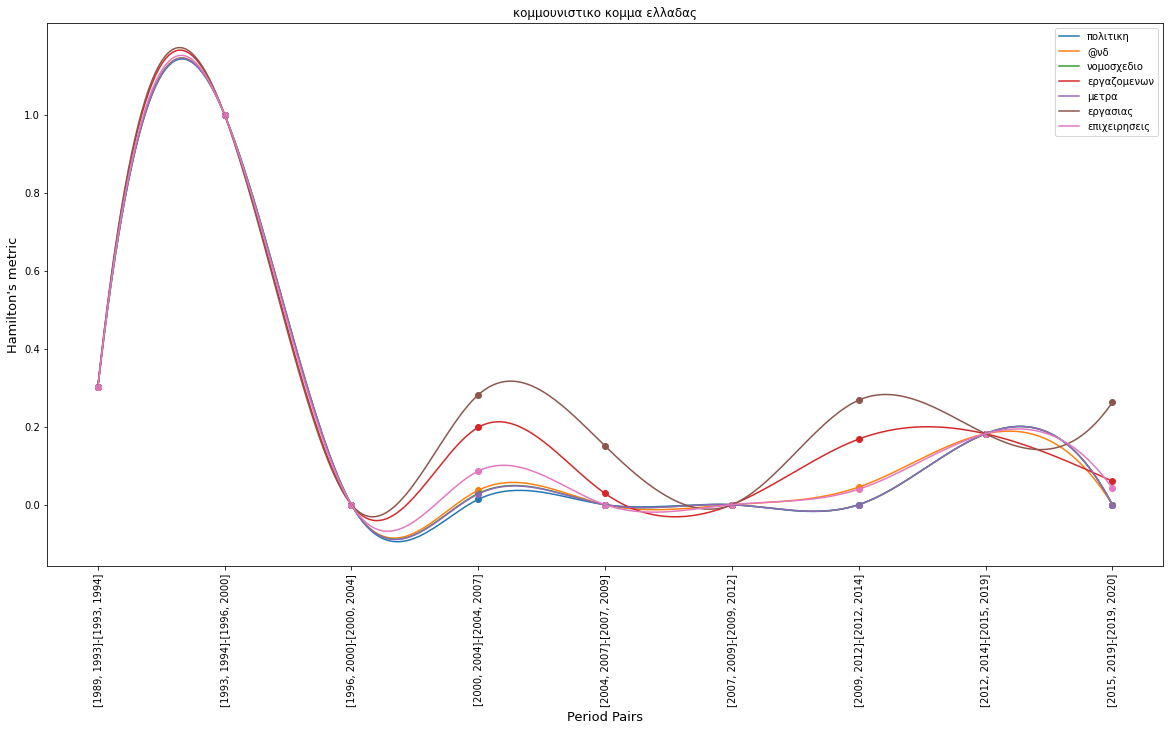

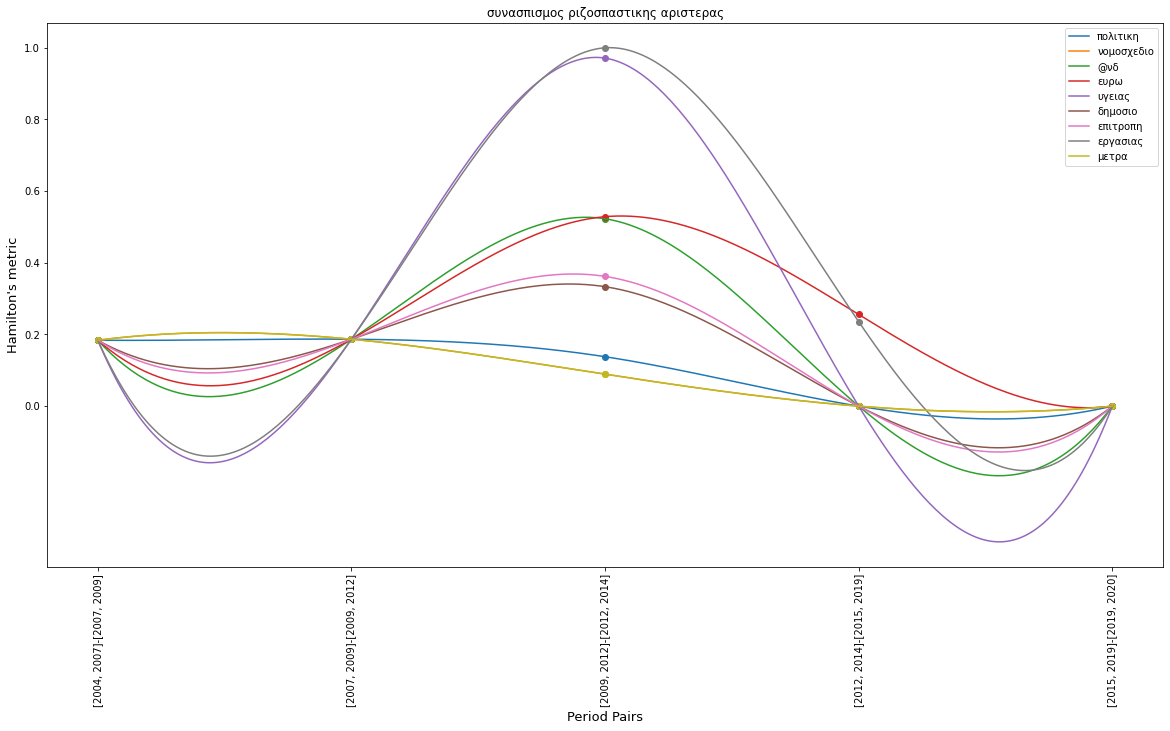

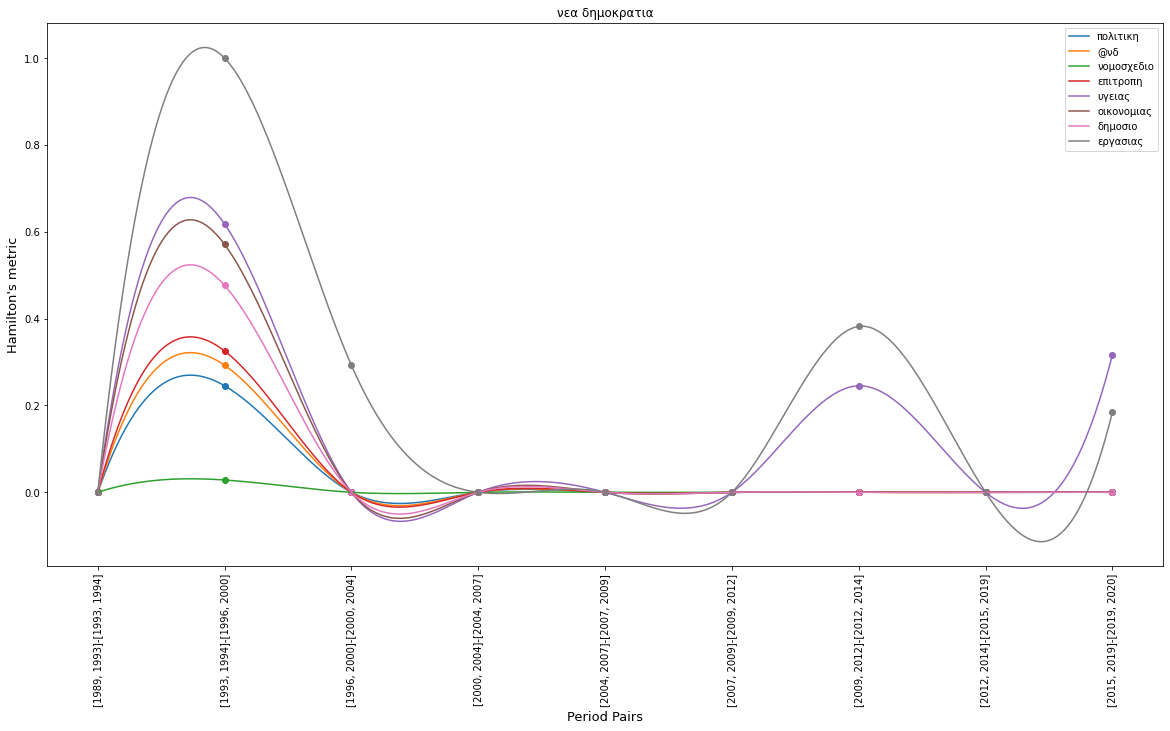

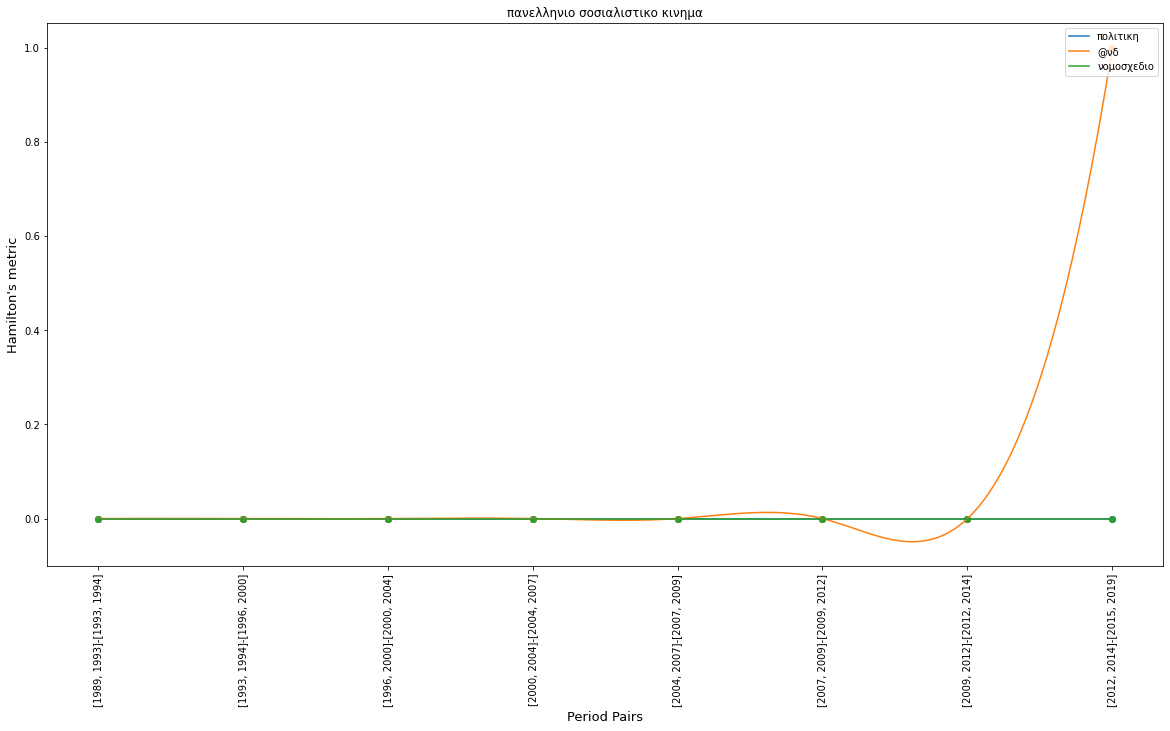

In [44]:
import decimal

all_sims = []
def drange(x, y, jump):
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)

for party in parties_selected:
    party_sims = []
    for topic in words_to_analyse[party]:
        df = for_plot_smoothed_all.loc[
            (for_plot_smoothed_all.parties == party) & (for_plot_smoothed_all.topics == topic)].reset_index()
        if len(df.all_similarities) == 0:
            continue

        similarities = df.all_similarities[0]
        
        if party == 'πανελληνιο σοσιαλιστικο κινημα':
            x_values = all_pairs[:-1]
            #x_values = grouped_data.loc[grouped_data.political_party == 'πανελληνιο σοσιαλιστικο κινημα'].year.unique()
        elif party == 'συνασπισμος ριζοσπαστικης αριστερας':
            x_values = all_pairs[4:]
            #x_values = grouped_data.loc[grouped_data.political_party == 'συνασπισμος ριζοσπαστικης αριστερας'].year.unique()
        else:
            #print(len(similarities))
            x_values = all_pairs
            
        #similarities = similarities/max(similarities)
        party_sims.extend(similarities)
        all_sims.extend(similarities)
        plt.scatter(x=list(range(len(similarities))), y=similarities)
        #print(df.all_similarities[0][0:5])
        xnew = np.linspace(0, len(similarities)-1, 300)
        spl = make_interp_spline(range(len(similarities)), similarities, k=3)
        power_smooth = spl(xnew)
        plt.xticks(list(range(len(x_values))), x_values)
        plt.plot(xnew, power_smooth, label = topic)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right',prop={'size': 10})
    plt.rcParams['figure.figsize'] = (20, 10)
    plt.title(party)
    plt.ylabel('Hamilton\'s metric', fontsize=13)
    plt.xlabel('Period Pairs', fontsize=13)
    plt.xticks(list(range(len(x_values))), x_values)
    step = (max(party_sims)-min(party_sims))/5
    plt.yticks(np.arange(min(party_sims),max(party_sims)+0.01,step), np.round(np.arange(0,1.1,0.2), 1))
    #plt.ylim([-3, 3])
    plt.savefig(f"../cosine_sim_plots/goldberg_many_topics_one_party-{party}.jpg")
    plt.show()
    plt.close()

### Word Frequency

In [49]:
grouped_data.parliamentary_period.unique()

array(['period 7', 'period 8', 'period 9', 'period 10', 'period 11',
       'period 12', 'period 13', 'period 15', 'period 17',
       'period 18 review 9'], dtype=object)

In [65]:
periods_in_years = [i[1] for i in min_max_years.items()]
periods_in_years

[[1989, 1993],
 [1993, 1994],
 [1996, 2000],
 [2000, 2004],
 [2004, 2007],
 [2007, 2009],
 [2009, 2012],
 [2012, 2014],
 [2015, 2019],
 [2019, 2020]]

In [66]:
def word_frequency_per_party(party):
    for topic in words_to_analyse[party]:
        topic_sims = []
        x_values = periods_in_years
        for period in grouped_data.parliamentary_period.unique():
            #x_values.append(period)
            try:
                model = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{period}.mdl")
                topic_sims.append(model.wv.vocab[topic].count)
                #print(model.wv.vocab[topic].count)
            except:
                topic_sims.append(0)

        if not topic_sims:
            continue
        plt.scatter(x=list(range(len(topic_sims))), y=topic_sims)
        #print(df.all_similarities[0][0:5])
        xnew = np.linspace(0, len(topic_sims)-1, 300)
        spl = make_interp_spline(range(len(topic_sims)), topic_sims, k=3)
        power_smooth = spl(xnew)
        #plt.xticks(list(range(len(x_values))), x_values)
        plt.plot(xnew, power_smooth, label = topic)
        plt.xticks(rotation=90)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper right',prop={'size': 10})
        plt.rcParams['figure.figsize'] = (20, 10)
        plt.title(party)
        plt.ylabel('Word Frequency', fontsize=13)
        plt.xlabel('Period', fontsize=13)
        plt.xticks(list(range(len(x_values))), x_values)
        #plt.ylim([-3, 3])
        plt.savefig(f"../cosine_sim_plots/word_frequency-{party}-{topic}.jpg")
        plt.show()
        plt.close()

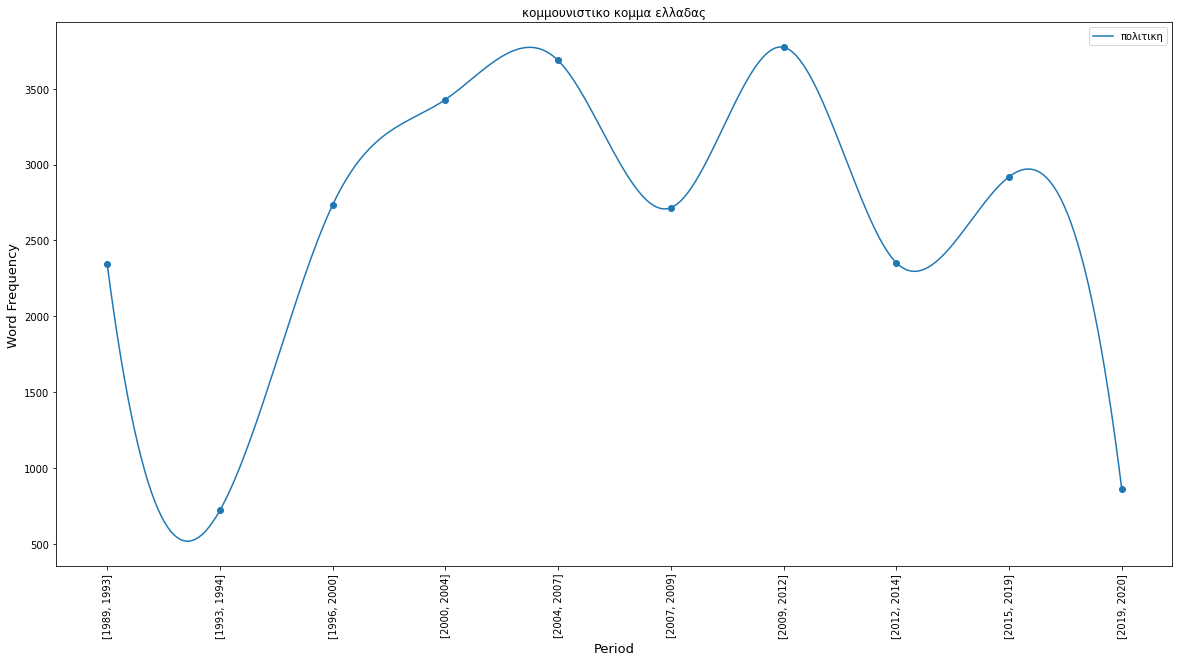

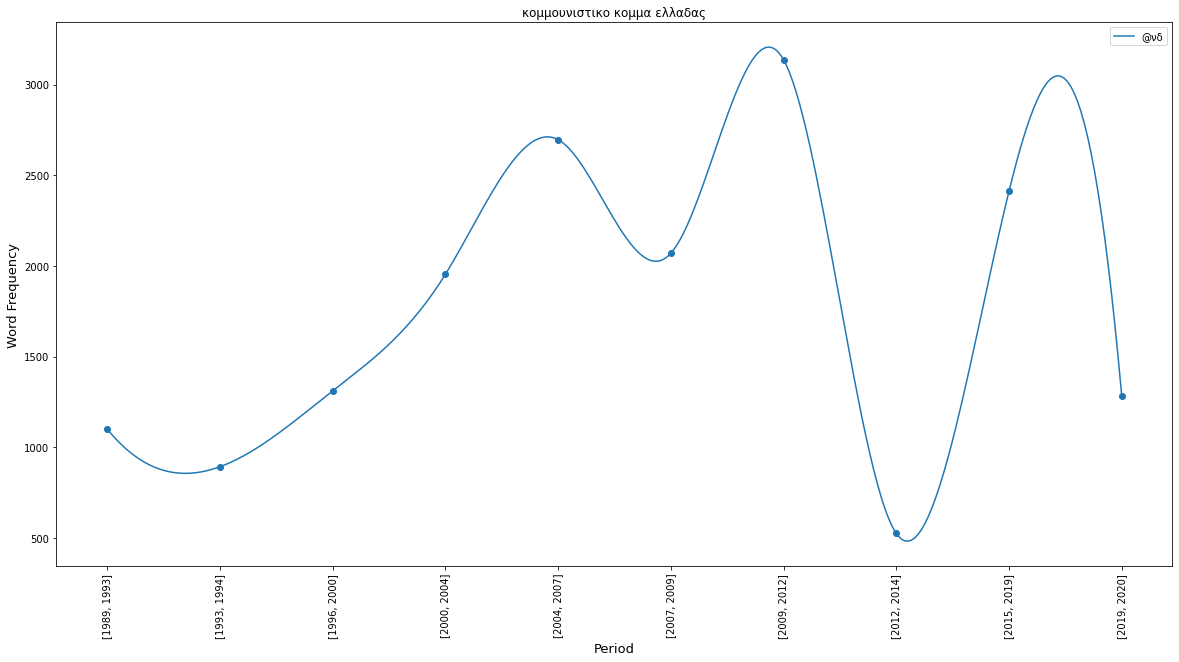

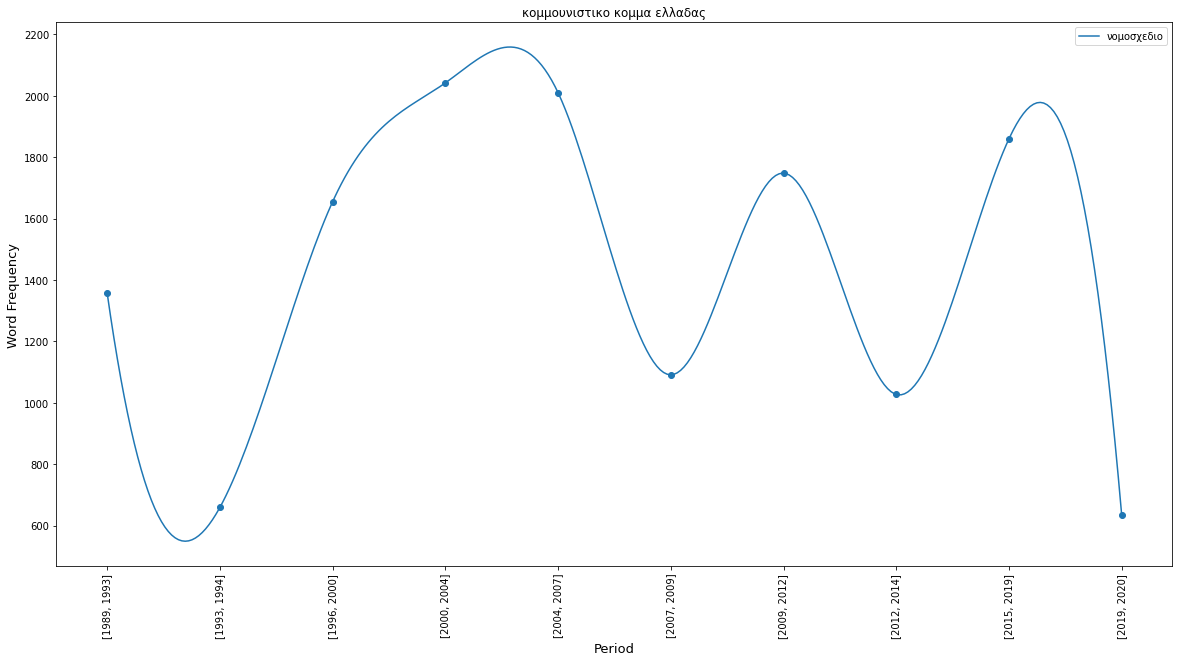

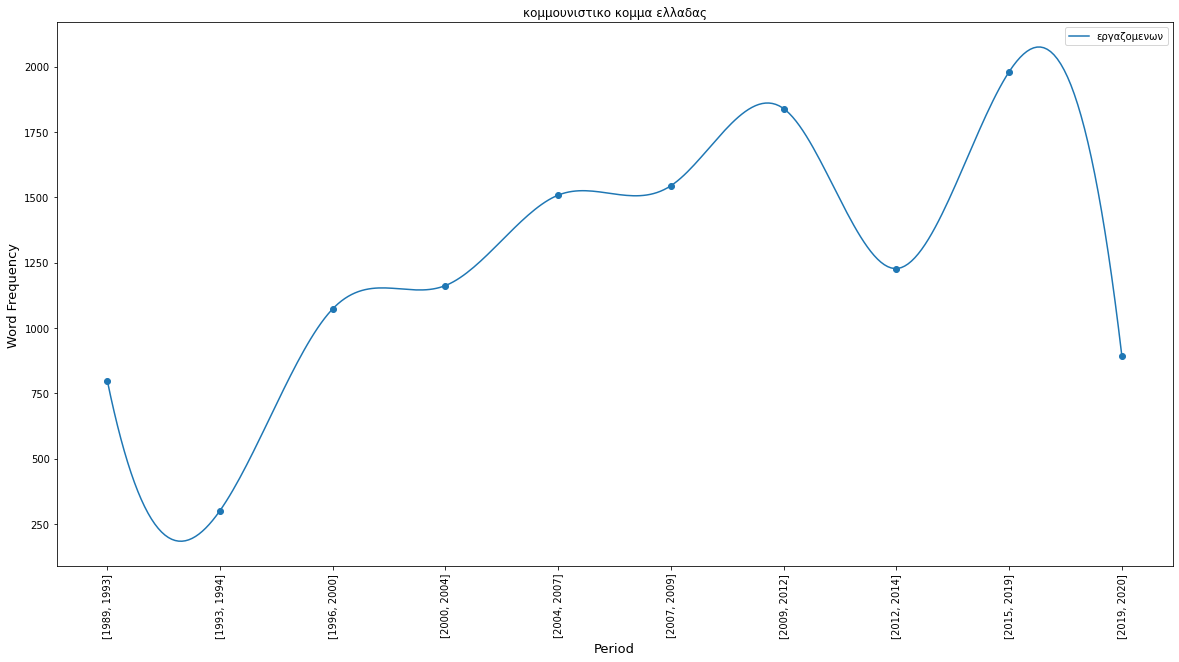

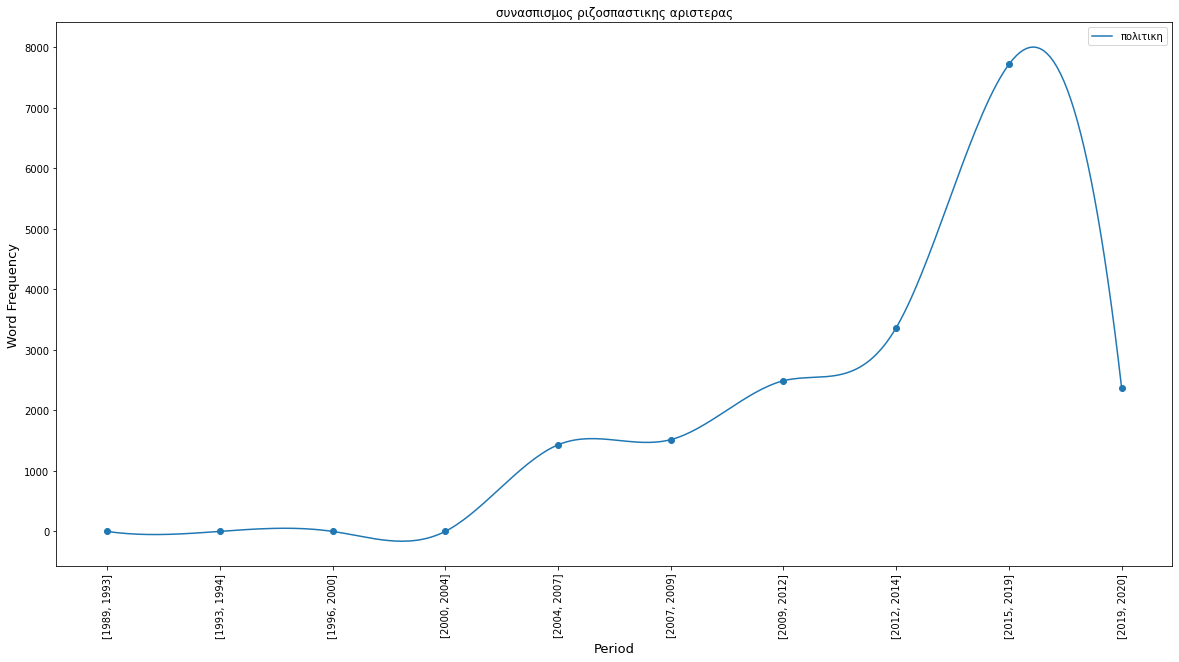

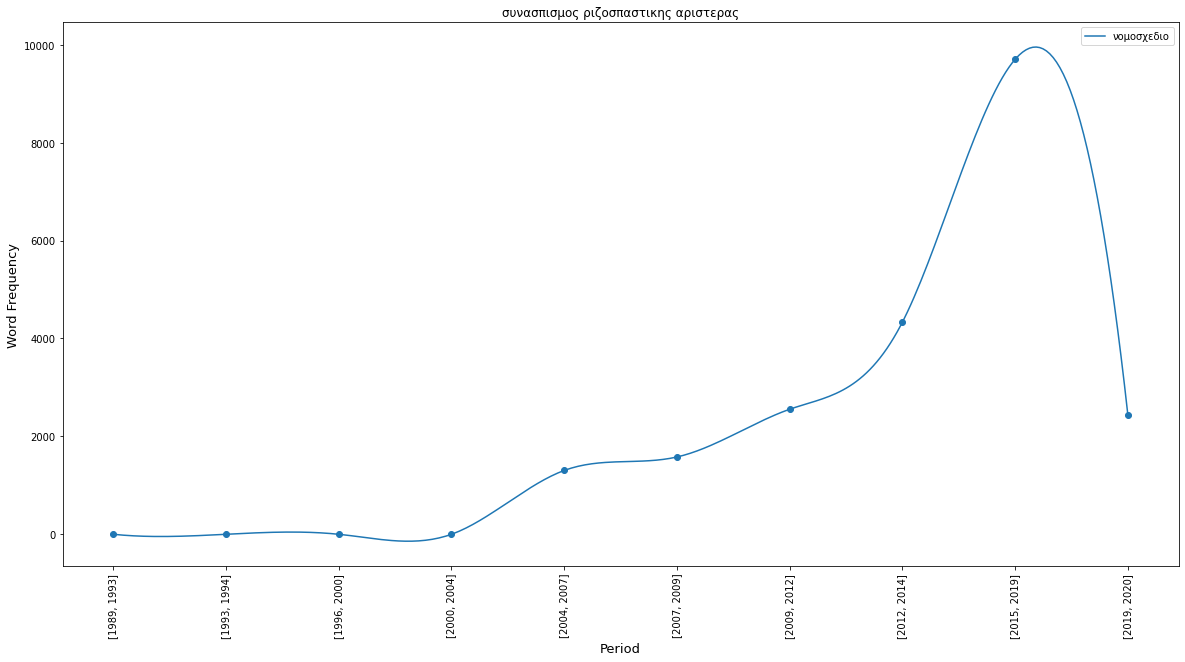

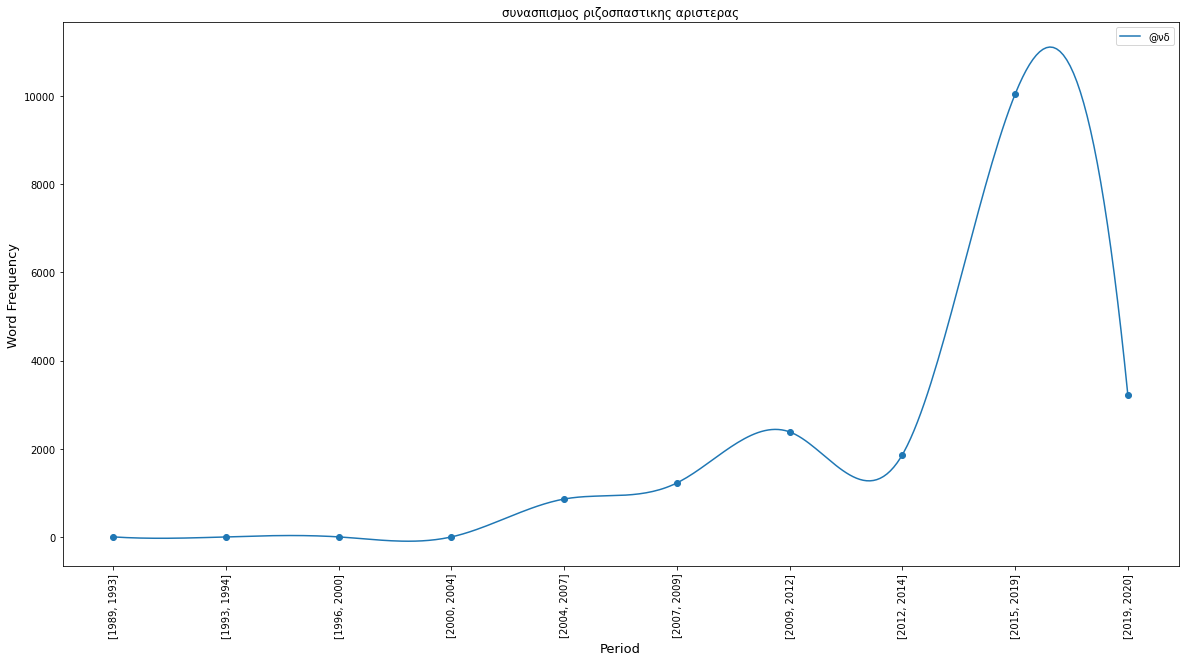

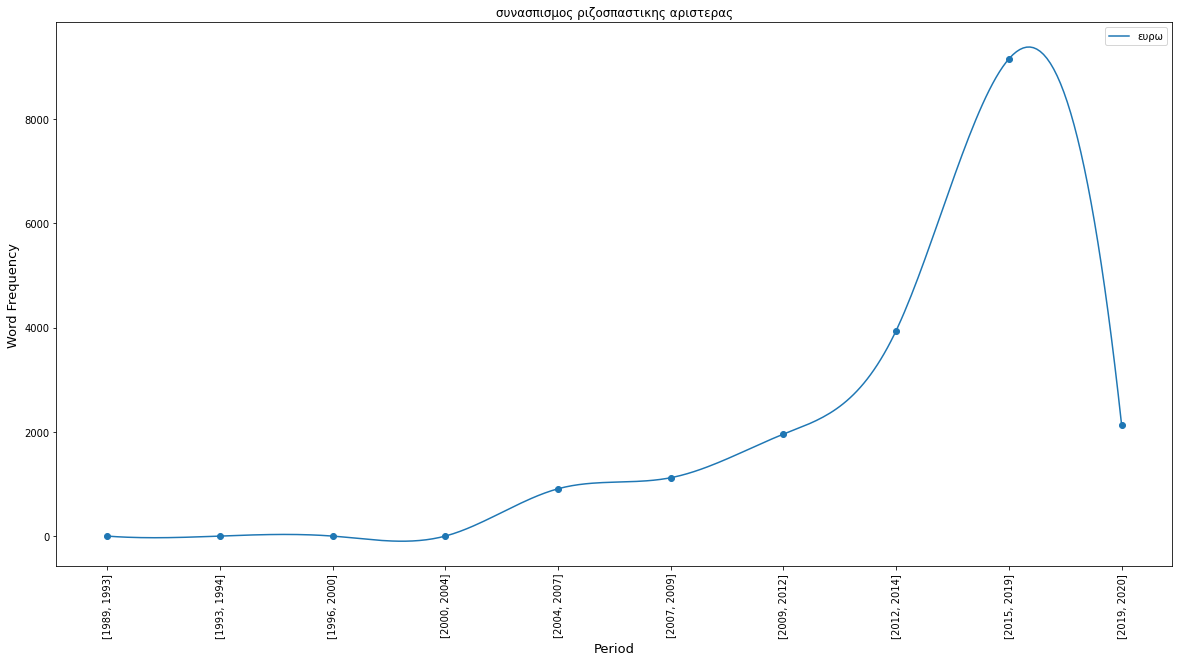

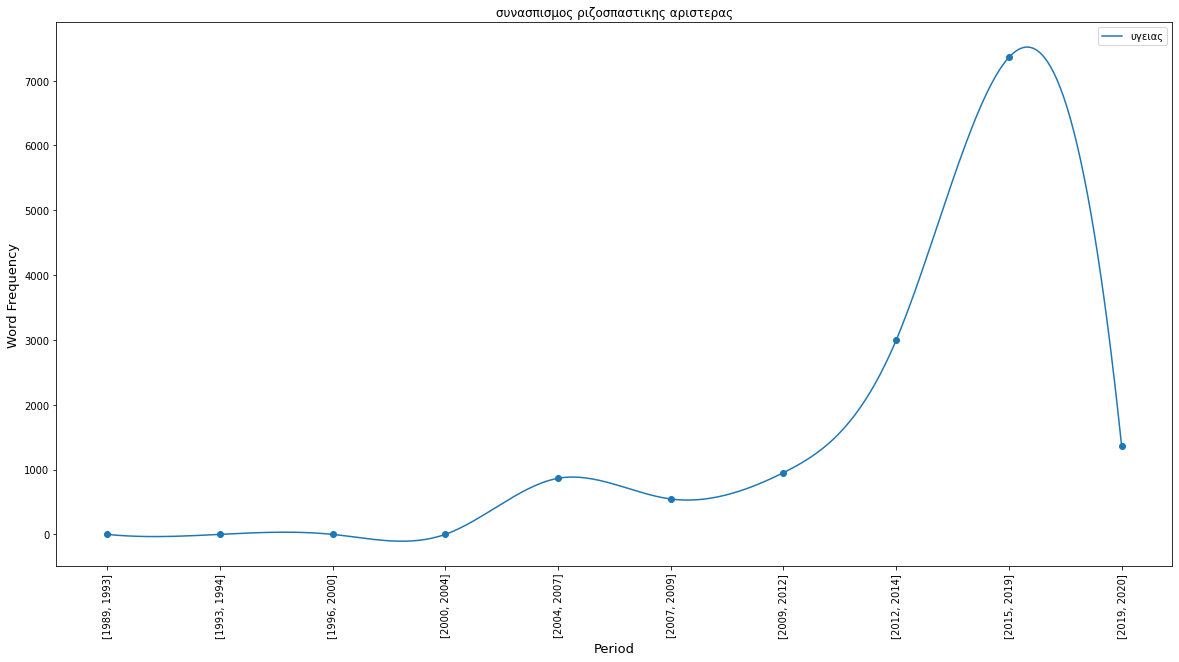

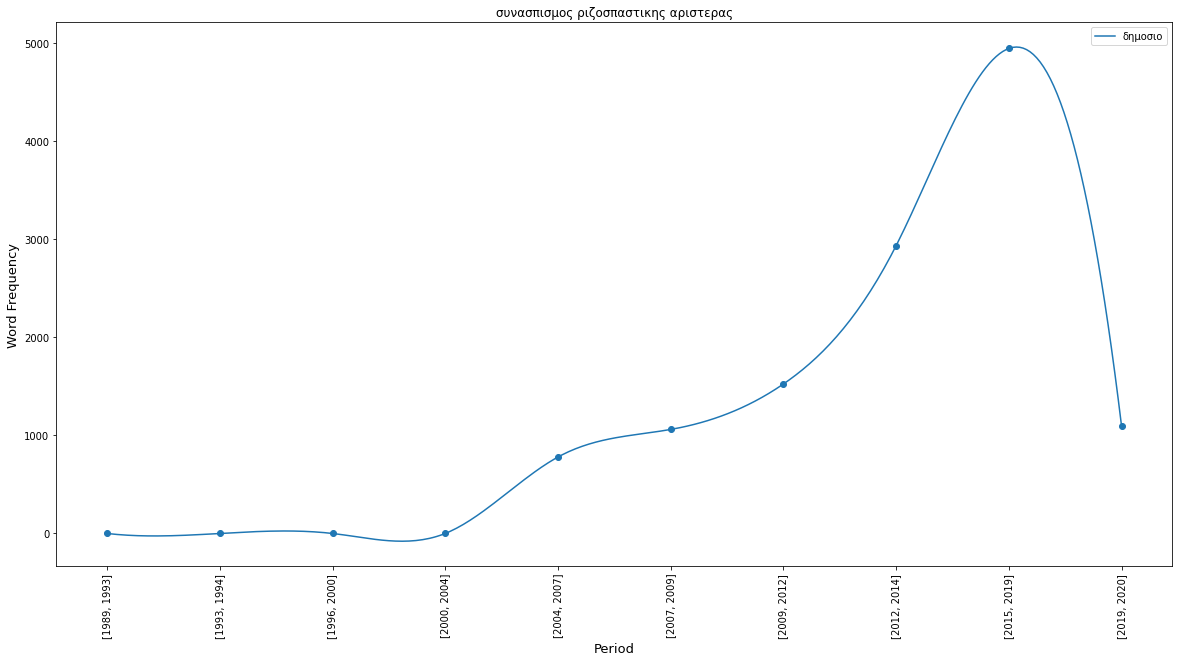

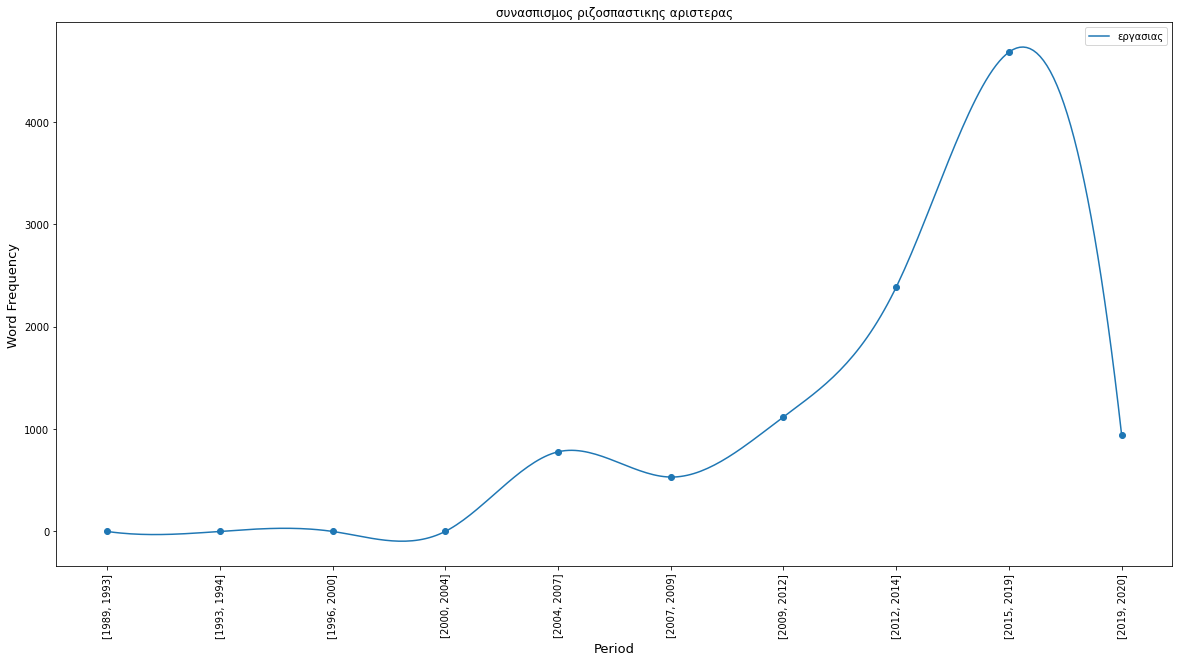

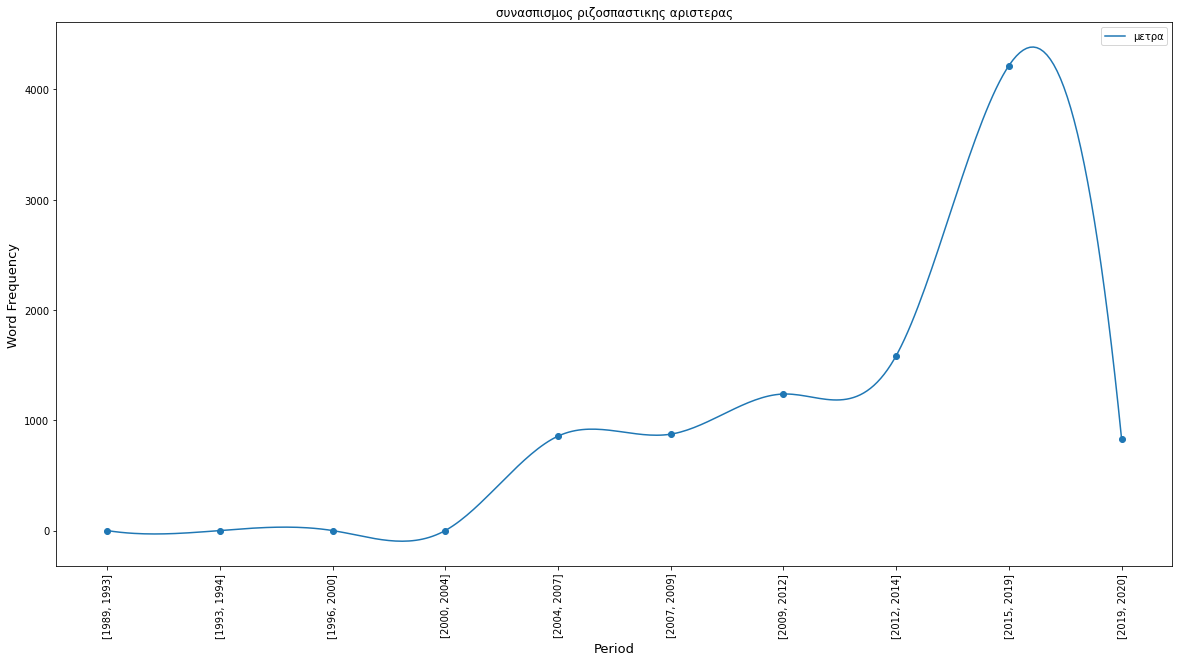

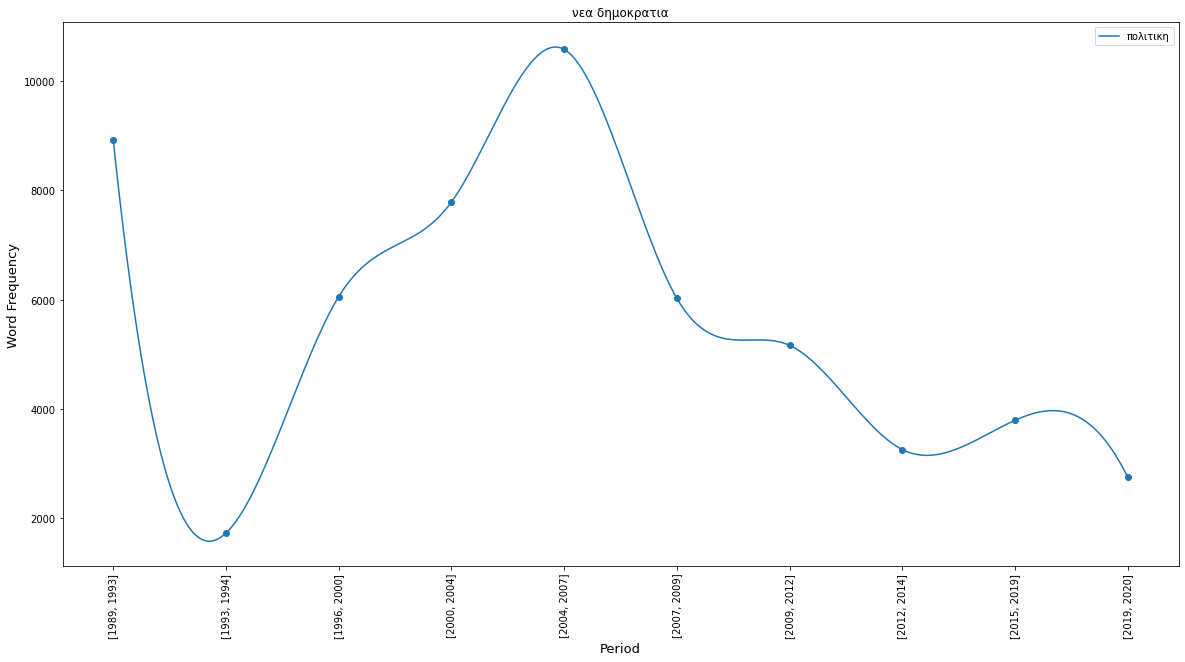

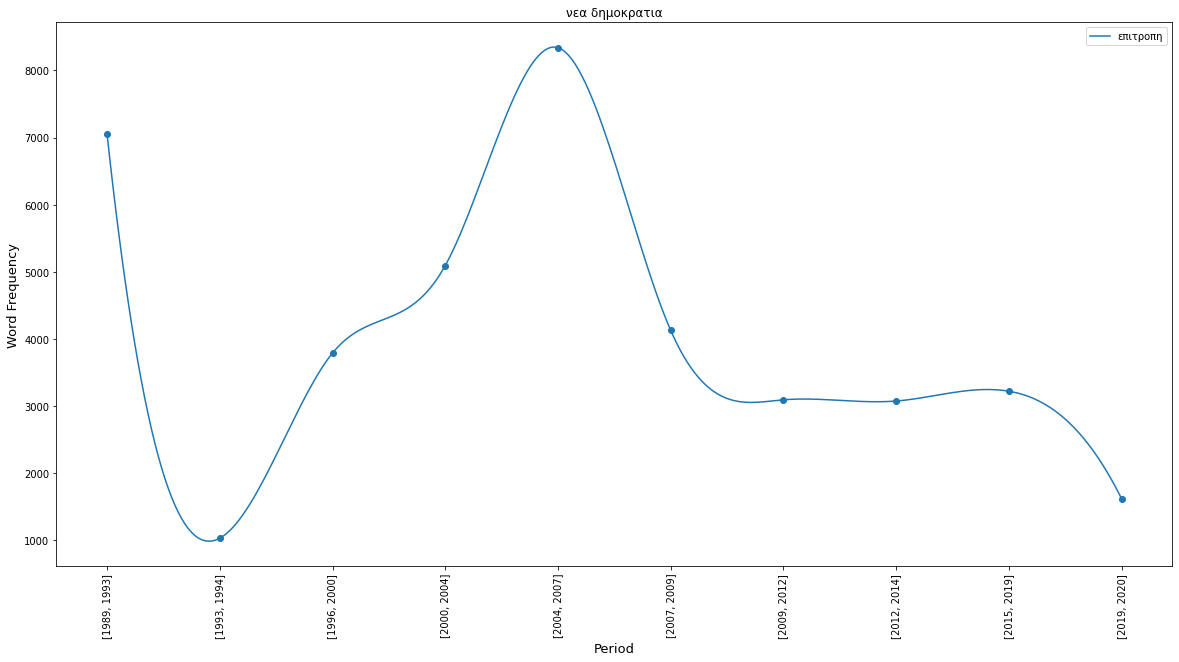

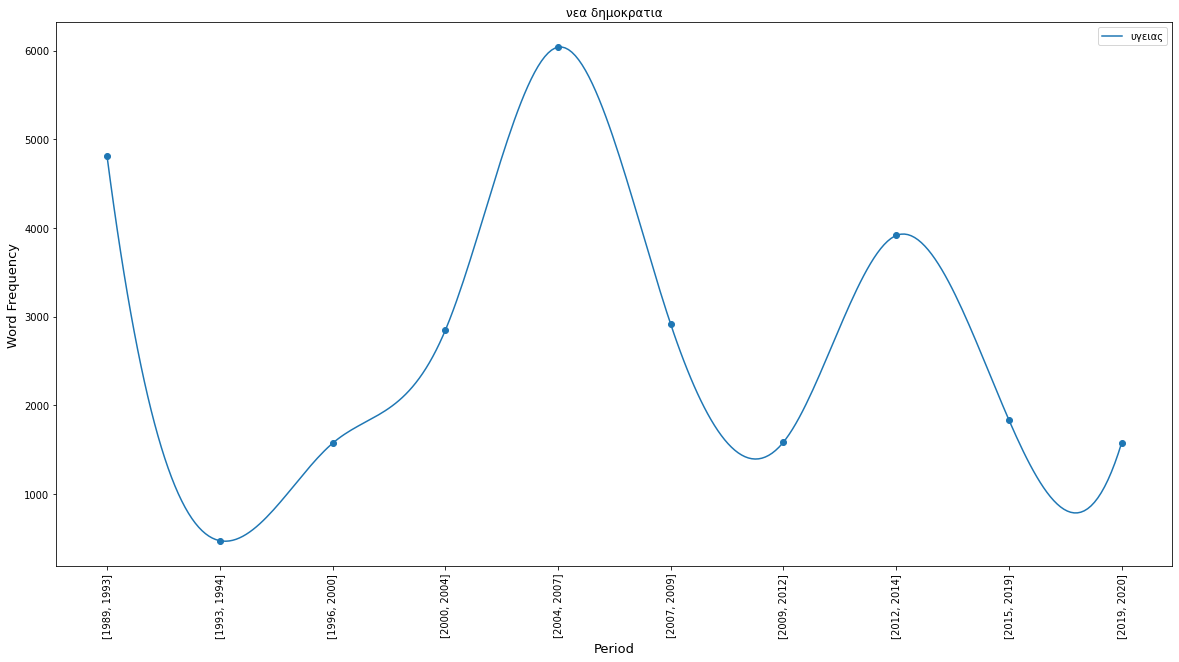

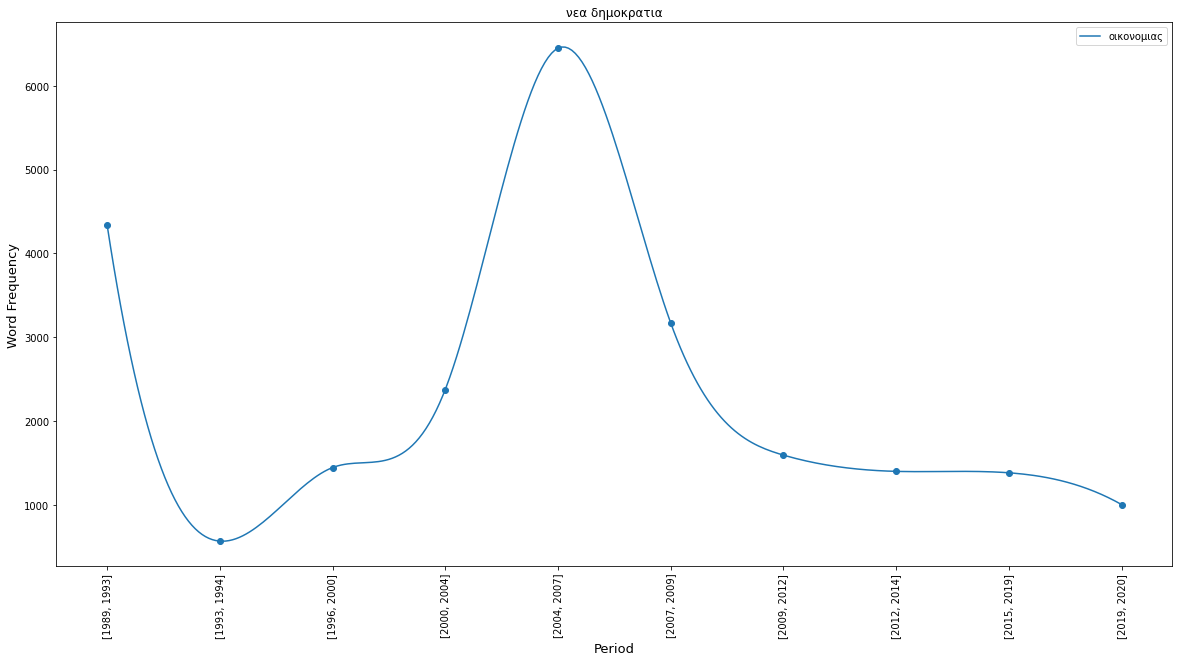

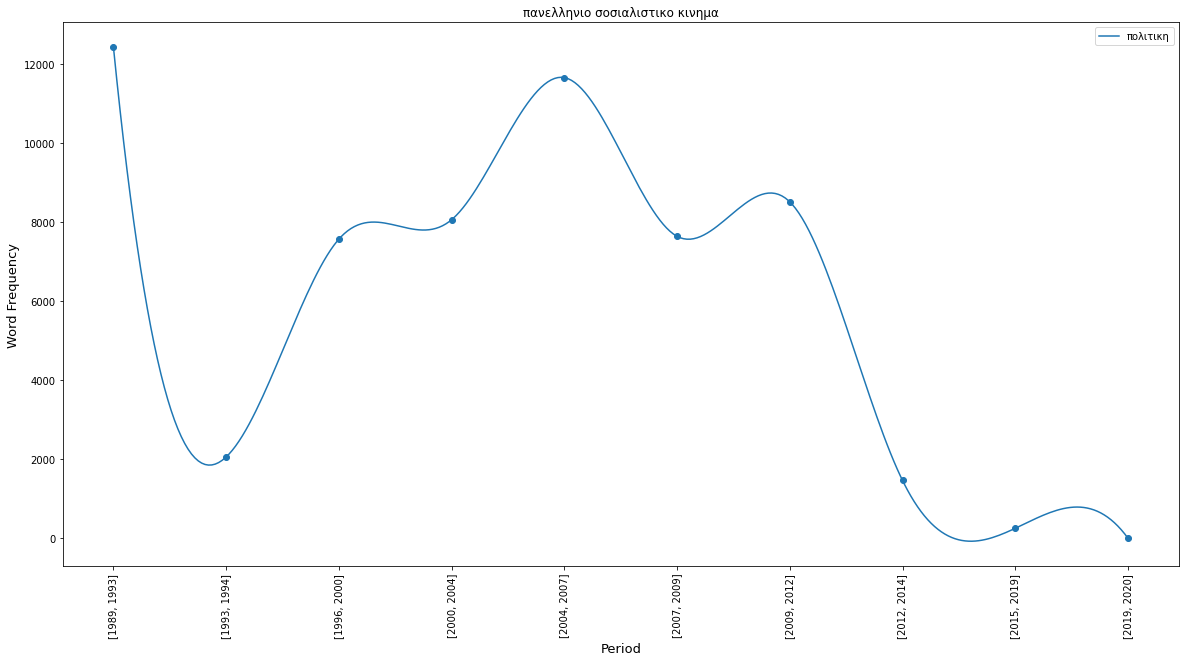

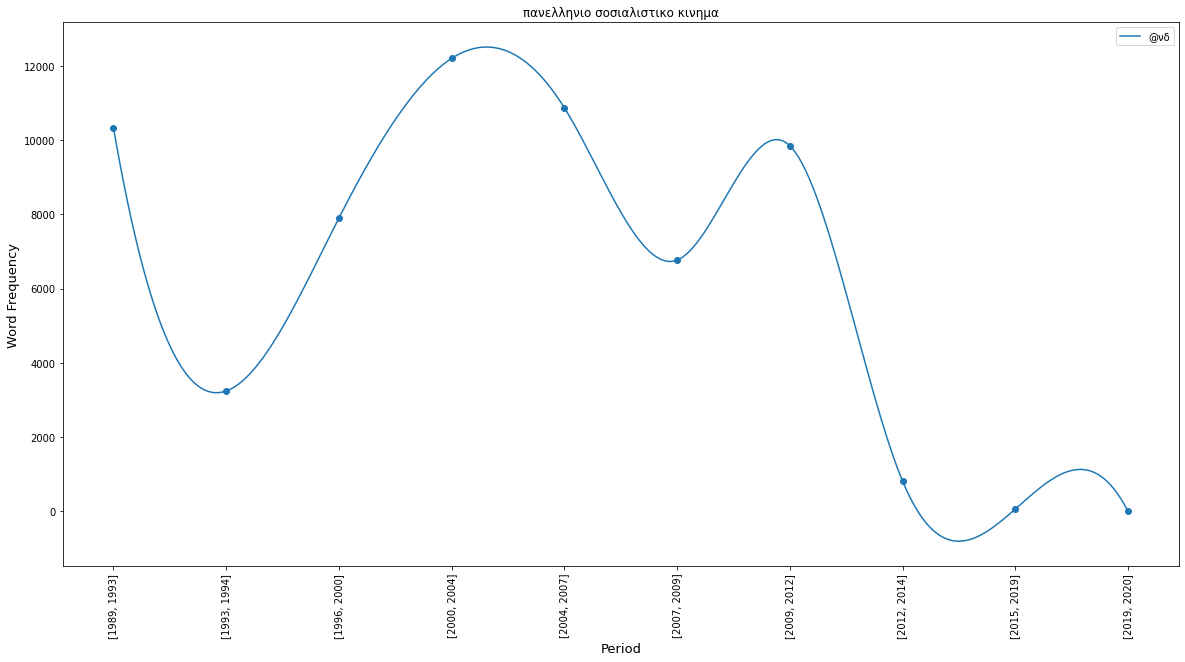

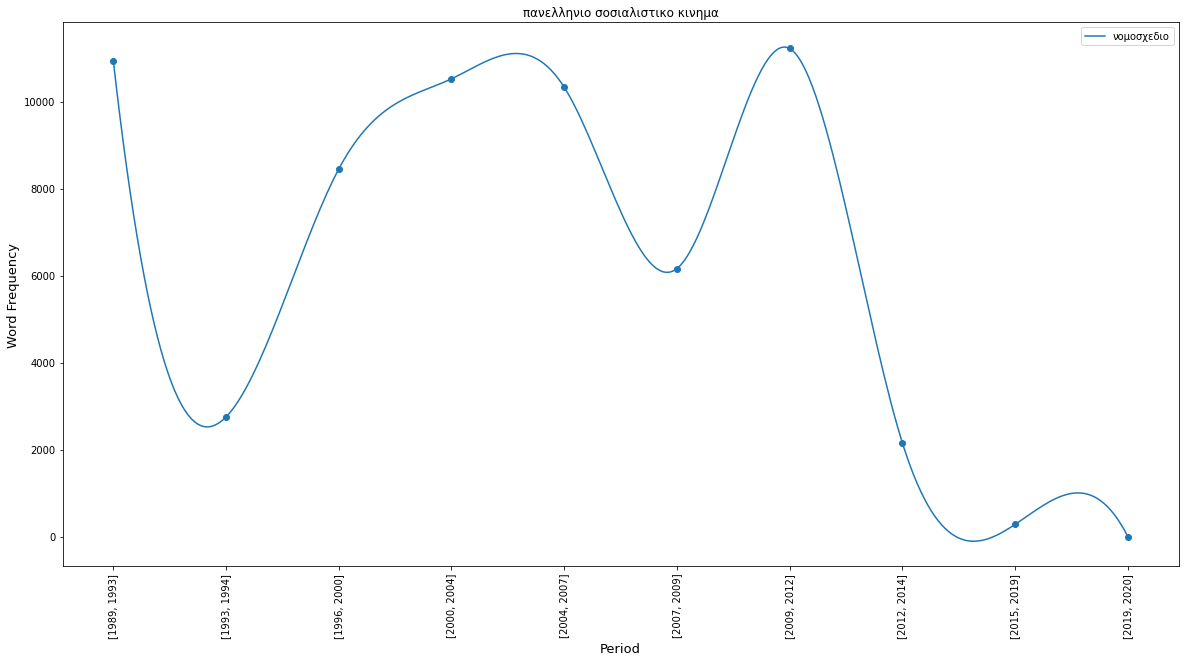

In [67]:
for party in parties_selected:
    word_frequency_per_party(party)

Words with lower frequency seem to have greater semantic shift

### Neighbours

In [39]:
df_intersections.head()

topic                      parties            time_points  intersection  \
0  πολιτικη  κομμουνιστικο κομμα ελλαδας    period 7 - period 8          -780   
1  πολιτικη  κομμουνιστικο κομμα ελλαδας    period 8 - period 9          -269   
2  πολιτικη  κομμουνιστικο κομμα ελλαδας   period 9 - period 10         -1000   
3  πολιτικη  κομμουνιστικο κομμα ελλαδας  period 10 - period 11          -990   
4  πολιτικη  κομμουνιστικο κομμα ελλαδας  period 11 - period 12         -1000   

                                    neighbors_before  \
0  ['μααστριχτ', 'κατευθυνση', 'συνθηκη', 'λογικη...   
1  ['πολιτικης', 'προγραμμα', 'προβληματα', '@νδ'...   
2  ['κατευθυνση', 'προσπαθεια', 'ευθυνη', 'αντιλα...   
3  ['πλευρα', 'τακτικη', 'κατευθυνση', 'μετρα', '...   
4  ['επιλογη', 'προσπαθεια', 'πολιτικης', 'εξουσι...   

                                     neighbors_after  \
0  ['πολιτικης', 'προγραμμα', 'προβληματα', '@νδ'...   
1  ['κατευθυνση', 'προσπαθεια', 'ευθυνη', 'αντιλα...   
2  ['πλευρα', 'τακτικη', 'κατευθυνση', 'μετρα', '...   
3  ['επιλογη', 'προσπαθεια', 'πολιτικης', 'εξουσι...   
4  ['κατευθυνση', 'πορεια', 'αποτελεσματα', 'λογι...   

                 year_points  
0  [1989, 1993]-[1993, 1994]  
1  [1993, 1994]-[1996, 2000]  
2  [1996, 2000]-[2000, 2004]  
3  [2000, 2004]-[2004, 2007]  
4  [2004, 2007]-[2007, 2009]

In [40]:
## check kke mins neighbors

filter_kke = df_intersections[(df_intersections.parties=='κομμουνιστικο κομμα ελλαδας')&
                 (df_intersections.time_points=='period 8 - period 9')&
                 (df_intersections.topic.isin(words_to_analyse['κομμουνιστικο κομμα ελλαδας']))]
for topic in filter_kke.topic:
    print(topic)
    print(filter_kke[filter_kke.topic==topic].neighbors_before.iloc[0][0:100])
    print(filter_kke[filter_kke.topic==topic].neighbors_after.iloc[0][0:100])#it is saved in text

πολιτικη
['πολιτικης', 'προγραμμα', 'προβληματα', '@νδ', 'κυβερνησεις', 'εοκ', '@πασοκ', 'χωρας', 'κυβερνηση'
['κατευθυνση', 'προσπαθεια', 'ευθυνη', 'αντιλαικη', 'στοχους', 'αντιληψη', 'ονε', 'πορεια', 'κυβερνη
@νδ
['@πασοκ', 'κυβερνηση', 'προγραμμα', 'λογικη', 'κυβερνησης', 'κομματα', 'πολιτικη', 'πλευρα', 'κανει
['@πασοκ', '@συνασπισμος', '@κκε', 'ελεγε', 'κυβερνηση', 'αντιπολιτευση', 'κομματων', 'κομματος', 'θ
νομοσχεδιο
['συζητηση', '@κκε', 'επιτροπη', 'νομιζω', 'βουλευτες', 'θεμα', 'κανουμε', 'πει', 'βουλη', 'προταση'
['προταση', 'συζητηση', 'λογους', 'νομου', 'νομοσχεδιου', 'ειπαμε', 'νομος', 'σχεδιο', 'αρχη', 'διαδ
εργαζομενων
['ενωσης', 'λαου', 'βαρος', 'χωρα', 'ελλαδα', 'αγροτικη', 'αναπτυξη', 'μετρα', 'εργαζομενους', 'χωρα
['αγροτων', 'κινηματος', 'ελληνικου', 'μικρομεσαιων', 'λαικων', 'ζωης', 'βαρος', 'λαικα', 'μαζικης',
μετρα
['βαρος', 'εοκ', 'συμφεροντα', 'εργαζομενων', 'χωρα', 'ελλαδα', 'εργαζομενους', 'ενωσης', 'λαου', 'π
['κυβερνησεις', 'παρθουν', 'λαο', 'ελληνικο', 'πο

In [41]:
## check kke mins neighbors

filter_syriza = df_intersections[(df_intersections.parties=='συνασπισμος ριζοσπαστικης αριστερας')&
                 (df_intersections.time_points=='period 15 - period 17')&
                 (df_intersections.topic.isin(words_to_analyse['συνασπισμος ριζοσπαστικης αριστερας']))]
for topic in ['εργασιας', 'υγειας']:
    print(topic)
    print(filter_syriza[filter_syriza.topic==topic].neighbors_before.iloc[0][0:120])
    print(filter_syriza[filter_syriza.topic==topic].neighbors_after.iloc[0][0:120])#it is saved in text

εργασιας
['ασφαλισης', 'συλλογικες', 'απασχολησης', 'προνοιας', 'συλλογικη', 'θεσεις', 'συμβασεις', 'ναυτιλιας', 'τουρισμου', 'κα
['απασχολησης', 'πληρους', 'οργανικες', 'οικονομικων', 'συλλογικες', 'κενες', 'συλλογικων', 'μονιμες', 'απολυσεων', 'εργ
υγειας
['παιδειας', 'τουρισμου', 'εκπαιδευτικο', 'πολιτισμου', 'ναυτιλιας', 'εκπαιδευσης', 'πρωτοβαθμια', 'φροντιδας', 'περιθαλ
['περιθαλψης', 'φροντιδας', 'παιδειας', 'πρωτοβαθμια', 'εσωτερικων', 'ασφαλιστικου', 'σωφρονιστικο', 'πολιτισμου', 'φρον


In [42]:
## check kke mins neighbors

filter_nd = df_intersections[(df_intersections.parties=='νεα δημοκρατια')&
                 (df_intersections.time_points=='period 15 - period 17')&
                 (df_intersections.topic.isin(words_to_analyse['νεα δημοκρατια']))]
for topic in ['εργασιας', 'υγειας']:
    print(topic)
    print(filter_nd[filter_nd.topic==topic].neighbors_before.iloc[0][0:120])
    print(filter_nd[filter_nd.topic==topic].neighbors_after.iloc[0][0:120])#it is saved in text

εργασιας
['απασχολησης', 'εσωτερικων', 'ασφαλισης', 'προνοιας', 'σεπε', 'επικουρικων', 'επιθεωρησης', 'προκηρυξη', 'κοινωνικης', 
['απασχολησης', 'οικονομικων', 'ασφαλισης', 'υγειας', 'τουρισμου', 'ενεργειας', 'παιδειας', 'ναυτιλιας', 'υποδομων', 'ερ
υγειας
['παιδειας', 'πρωτοβαθμια', 'εκπαιδευσης', 'υπηρεσιων', 'εσωτερικων', 'τουρισμου', 'πολιτισμου', 'φροντιδας', 'δευτεροβα
['υποδομων', 'παιδειας', 'μεταφορων', 'πολιτισμου', 'τουρισμου', 'περιβαλλοντος', 'ναυτιλιας', 'εσωτερικων', 'αρμοδιο', 


In [43]:
## check kke mins neighbors

filter_pasok = df_intersections[(df_intersections.parties=='πανελληνιο σοσιαλιστικο κινημα')&
                 (df_intersections.time_points=='period 15 - period 17')&
                 (df_intersections.topic.isin(words_to_analyse['πανελληνιο σοσιαλιστικο κινημα']))]
for topic in ['@νδ']:
    print(topic)
    print(filter_pasok[filter_pasok.topic==topic].neighbors_before.iloc[0][0:120])
    print(filter_pasok[filter_pasok.topic==topic].neighbors_after.iloc[0][0:120])#it is saved in text

@νδ
['@sw@δημαρ', '@πασοκ', 'παπανδρεου', '@συριζα', 'πρωθυπουργο', 'κομματος', '@χα', 'τσιπρας', 'πρωθυπουργος', 'ελεγε', '
['χρειαζεται', 'νομου', 'πραγματικα', 'ξερετε', 'προταση', 'ζητημα', 'θεση', 'δυο', 'ρυθμιση', 'πραγματα', 'αληθεια', 'υ
